In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from IPython.display import clear_output

import os
import random

from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [7]:
train = pd.read_csv(r"New_train.csv")
test = pd.read_csv(r"Test.csv")

### SARIMAX

In [8]:
### Import Packages ###

import itertools
import statsmodels.api as sm

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = q = range(0, 3)
d = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                                #freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                #print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'], ascending=True, ignore_index=True).head(5)
    
    return ans_df
    
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
#sarimax_gridsearch(ts, pdq, pdqs, freq='M')

### Для каждого товара своя модель
#### ---
#### Для товаров с n_rows>2
#### Заполним пропуски в временных рядах
#### T1, nan_1, ... , nan_l, Tn - линейная заполнение ( D = (Tn-T1)/count(nan), nan = D*k + T1, k=1...l)
#### T1, T2, ... , Ti, nan , ... , nan, Tn - скользящее среднее
#### ---
#### Для товаров с n_rows=2
#### Среднее

In [9]:
def make_ts(data, window_size=2, method = 'linear'):
    '''
    input:
    method - linear or ma
    data - data with columns sellout and nth_month
    window_size - window size for moving average
    
    if method = linear or smart then window_size do nothing
    '''
    sellouts = data.sellout.reset_index(drop=True)
    months = data.nth_month.reset_index(drop=True)
    sellouts_before_fill = []
    for i in range(len(sellouts)):
        try:
            n_missing_values = months[i+1] - months[i] - 1
            sellouts_before_fill += [sellouts[i]] + [np.nan]*n_missing_values
        except:
             sellouts_before_fill += [sellouts[i]]

    months = np.arange(min(months), max(months)+1)  
    sellouts_before_fill = pd.Series(sellouts_before_fill, index = months)
    new_sellouts = fill_missing_values(sellouts_before_fill.copy(), window_size, method)
    
    # plt.title(data.sku_name.unique()[0]) #always alone sku_name
    # plt.plot(new_sellouts, marker = '.', color = 'green')
    # plt.plot(sellouts_before_fill, marker = 'o', color = 'blue')
    # plt.legend(['filled data','source data'])
    # plt.show()
    
    return new_sellouts
    
    
        
def fill_missing_values(ts, window_size, method):
    if method == 'ma':
        linear_interpol(ts, window_size)
        for i in ts.index:
            if np.isnan(ts[i]):
                ts[i] = ts[i-window_size:i].mean()
    elif method == 'linear':
        ts.interpolate(method='linear', inplace=True)
    elif method == 'smart':
        ts = smart_filling(ts)
    return ts
            
    
def linear_interpol(ts, min_row):
    while True:
        if np.isnan(ts[:min_row]).sum() == 0:
            break
        else:
            start = end =-1
            for i in ts.index:
                if start == -1 and np.isnan(ts[i]):
                    start = i - 1
                elif start!=-1 and not np.isnan(ts[i]):
                    end = i+1
                if start!=-1 and end!=-1:
                    ts[start:end].interpolate(method='linear', inplace=True)
                    break
                    
def smart_filling(ts):
    '''
    mod=0 nothing
    mod=1 filling
    first loop - for pattern
    second loop - for peaks moments
    in the end linear filling default intervals
    '''
    mod=0
    index_to_skip=-1
    
    for i in ts.index:
        try:
            if mod == 1 and i!=index_to_skip:
                index1 = random.choice(non_na_elements_for_fill) 
                index2 = random.choice(non_na_elements_for_fill) 
                ts[i] = (ts[index1] + ts[index2])/2
                if not np.isnan(ts[i+1]):
                    mod=0

            elif np.isnan(ts[i]) and ts[i+1]/ts[i-1] > 1.5 and mod == 0:
                ts[i] = (ts[i-1] + ts[i-2])/2
                mod = 1
                non_na_elements_for_fill = []
                index_to_skip = i+1 
                for j in ts[ts>=0].index:
                    if j > i+1 and len(non_na_elements_for_fill)<3:
                        non_na_elements_for_fill.append(j)
        except:
            continue
            
    for i in ts.index:
        try:
            if mod == 1:
                index1 = random.choice(non_na_elements_for_fill) 
                index2 = random.choice(non_na_elements_for_fill) 
                ts[i] = (ts[index1] + ts[index2])/2
                if not np.isnan(ts[i+1]):
                    mod=0
            elif not np.isnan(ts[i]) and ts[i]/ts[i-1] > 1.5 and np.isnan(ts[i+1]) and mod == 0:
                mod=1
                non_na_elements_for_fill = []
                for j in ts[ts>=0].index:
                    if j > i and len(non_na_elements_for_fill)<3:
                        non_na_elements_for_fill.append(j)
        except:
            continue
    ts.interpolate(method='linear', inplace=True)
    return ts

### Последовательные умозаключения
#### ---
#### 1) Количество строк для товара > 2 слишком мягкое требование, так как если там всего 3 точки из 2016 года (то есть 1-12 месяцы), то может получится что для месяцев,
#### для которых нужно провести предсказание (то есть 71-74 месяцы, если учитывать 2020 год в подсчете номера месяца) будут гигантские значения
#### Пример: для YOSHWARDTERR имели (1:1013, 7:0, 10: 1013) в результате лучшей саримы получили (71: -1.8e34 ,72: 6e34, 73: -1.9e35, 74: 6e35)
#### 2) Так же использовать скользящее среднее для заполенения пропущенных значений плохая идея так как, если последним значением окажется выброс(большой пик), то все последующие
#### значения будут тоже большими, может получится подобие ступеньки
#### Пример: (..., 11:1000, 12: 70000, 28: 1000) -> (..., 11:1000, 12: 70000, [13: 35500, 14: 52 750, ..., 27: 47001], 28: 1000)
#### ---
#### В данных есть 2 часто встречающихся паттерна пропусков
#### 1) T1, nan, T_top, nan, nan, ..., nan, T2, T3, ... , где T_top - пиковое значение
#### 2) T1, T_top, nan, nan, ..., nan, T2, T3, ...
#### Поэтому сделаем способ дополения основанный на том, что промежутки дополняются на основании первых трех значениях, после промежутка пробелов
#### 1ый nan в 1) дополняется на основании ср афирм последних двух значений
#### ---

In [ ]:
lst=[]
columns=["Item_ID", "Target"]
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"]
times_for_pred=[71,72,73,74]



p = q = range(0, 2)
P = Q = range(0,2)
d = D = range(0, 2)
pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]


for sku_name in tqdm(test.sku_name.unique()):
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>15:
        ts = make_ts(train[train.sku_name == sku_name], method = 'smart')
        indexes_of_observations = ts.index
        ts_for_training = ts.reset_index(drop=True)
        configurations = sarimax_gridsearch(ts_for_training, pdq, PDQ, maxiter=50, freq='M')
        model = sm.tsa.statespace.SARIMAX(ts_for_training,
                                  order=configurations.loc[0,'pdq'],
                                  seasonal_order=configurations.loc[0,'pdqs'],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
        output = model.fit()
        result = output.predict()
        result.index = indexes_of_observations-1
        
        times_for_pred=np.array([71,72,73,74])
        times_for_pred = times_for_pred - indexes_of_observations[-1] + (len(result)-1)
        preds=[]
        for i, t in enumerate(times_for_pred):
            try:
                preds.append(output.predict(t).item())
                lst.append([sku_name + extra[i], output.predict(t).item()])
            except:
                preds.append(output.predict(t)[t])
                lst.append([sku_name + extra[i], output.predict(t)[t]])
       
        preds = pd.Series(data=preds, index=[71,72,73,74])
        print(f'---{sku_name}---')
        plt.title(f'SARIMA, {sku_name}')
        plt.plot(result)
        plt.plot(ts)
        plt.plot(preds)
        plt.legend(['sarima','true','sarima preds'])
        plt.show()
        
        
    if temp.shape[0] == 0:
        for i in range(4):
            lst.append([sku_name + extra[i], 1000])
    else:
        for i in range(4):
            lst.append([sku_name + extra[i], temp.sellout.mean()])
sub = pd.DataFrame(data=lst, columns = columns)

  0%|          | 0/382 [00:00<?, ?it/s]

#### Доработка плохих товаров, которые получили дикие оценки SARIMA

In [51]:
bad_sku_names = ['ARLEETTAAURE']

In [56]:
columns=["Item_ID", "Target"]
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"]
times_for_pred=[71,72,73,74]

p = q = range(0, 2)
d = range(0, 2)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for sku_name in bad_sku_names:
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>15:
#        ts = make_ts(train[train.sku_name == sku_name], method = 'smart')
#         indexes_of_observations = ts.index
#         ts_for_training = ts.reset_index(drop=True)
#         configurations = sarimax_gridsearch(ts_for_training, pdq, pdqs, maxiter=50, freq='M')
#         model = sm.tsa.statespace.SARIMAX(ts_for_training,
#                                   order=configurations.loc[0,'pdq'],
#                                   seasonal_order=configurations.loc[0,'pdqs'],
#                                   enforce_stationarity=False,
#                                   enforce_invertibility=False)
#         output = model.fit()
#         result = output.predict()
#         result.index = indexes_of_observations-1
        
#         times_for_pred=np.array([71,72,73,74])
#         times_for_pred = times_for_pred - indexes_of_observations[-1] + (len(result)-1)
#         preds=[]
#         for i, t in enumerate(times_for_pred):
#             index = sub[sub.Item_ID == sku_name + extra[i]].index
#             try:
#                 sub.loc[index,'Target'] = output.predict(t).item()
#                 preds.append(output.predict(t).item())
#             except:
#                 sub.loc[index,'Target'] = output.predict(t)[t]
#                 preds.append(output.predict(t)[t])

        # ts = make_ts(train[train.sku_name == sku_name], method = 'smart')
        # preds = pd.Series(data=preds, index=[71,72,73,74])
        # print(f'---{sku_name}---')
        # plt.title(f'SARIMA, {sku_name}')
        # plt.plot(result)
        # plt.plot(ts)
        # plt.plot(preds)
        # plt.legend(['sarima','true','sarima preds'])
        # plt.show()
        
        
        times_for_pred=np.array([71,72,73,74])
        times_for_pred = times_for_pred - indexes_of_observations[-1] + (len(result)-1)
        preds=[]
        for i, t in enumerate(times_for_pred):
            index = sub[sub.Item_ID == sku_name + extra[i]].index
            sub.loc[index,'Target'] = ts.mean()
            preds.append(ts.mean())
        
    if temp.shape[0] == 0:
        for i in range(4):
            lst.append([sku_name + extra[i], 1000])
    else:
        for i in range(4):
            lst.append([sku_name + extra[i], temp.sellout.mean()])

In [58]:
sub

Item_ID         Target
0     YOSHTLYNYOSHZZ_11_2021   32213.400000
1     YOSHTLYNYOSHZZ_12_2021   32213.400000
2      YOSHTLYNYOSHZZ_1_2022   32213.400000
3      YOSHTLYNYOSHZZ_2_2022   32213.400000
4       YOSHRENECARL_11_2021   99274.000000
...                      ...            ...
1927      ABEAHAMASHL_2_2022  164087.971136
1928     ABEAHAMASHL_11_2021  232154.719298
1929     ABEAHAMASHL_12_2021  232154.719298
1930      ABEAHAMASHL_1_2022  232154.719298
1931      ABEAHAMASHL_2_2022  232154.719298

[1932 rows x 2 columns]

In [59]:
sub.to_csv(os.getcwd()+'\submission 8 (sarima + mean, sarima if n_row 15, fill missing values smart, preds can be negative).csv',index=False)

  0%|          | 0/382 [00:00<?, ?it/s]

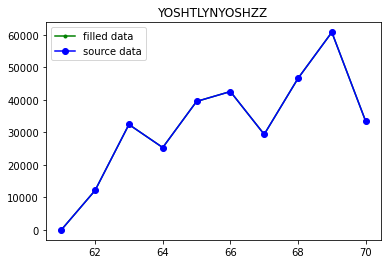

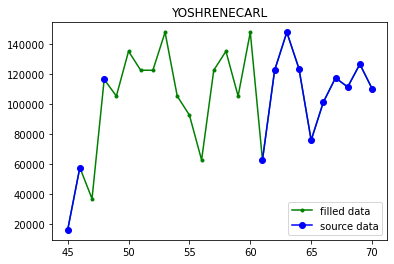

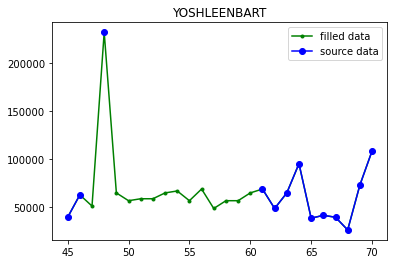

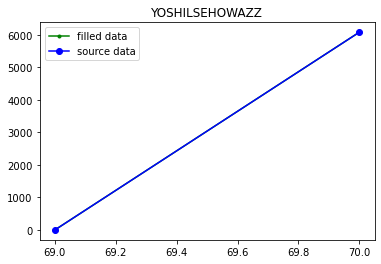

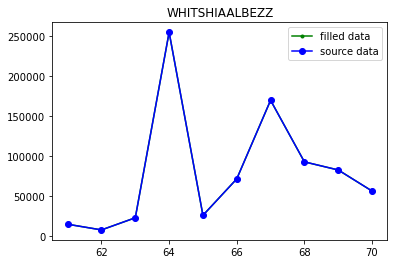

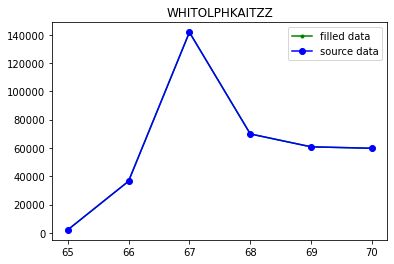

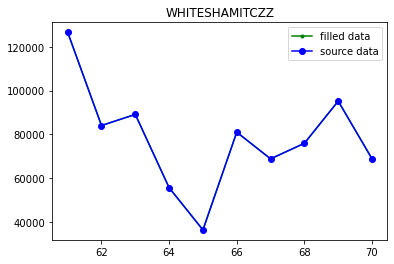

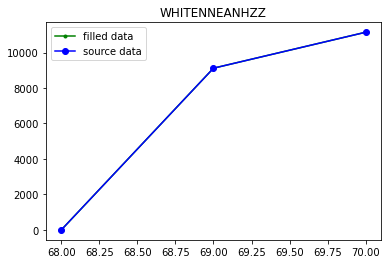

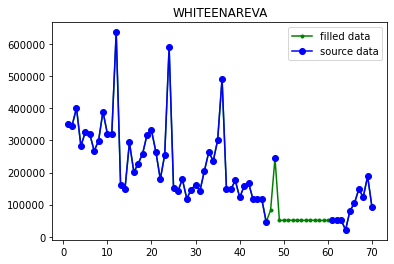

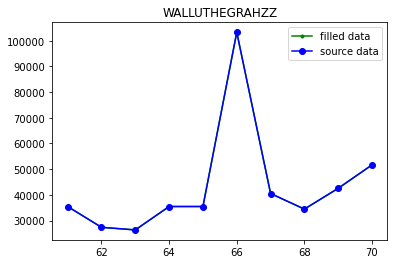

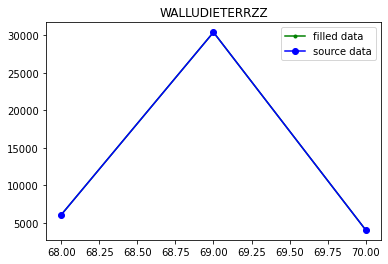

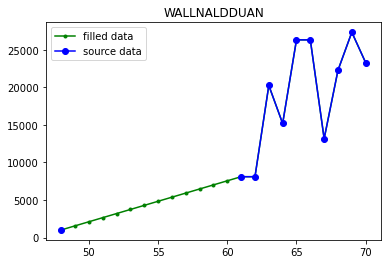

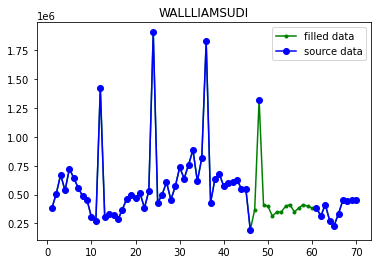

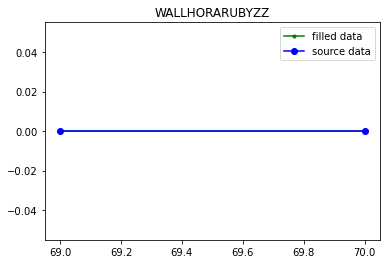

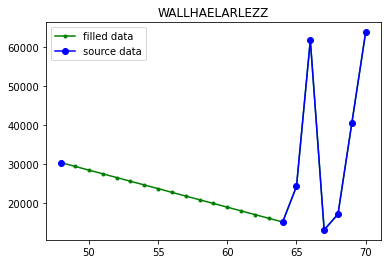

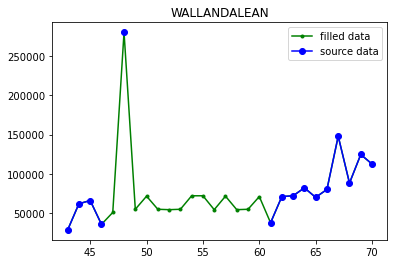

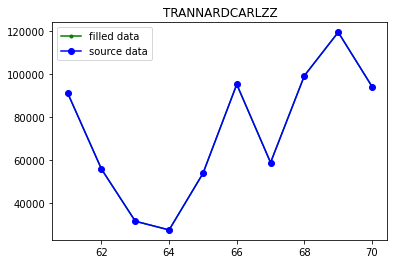

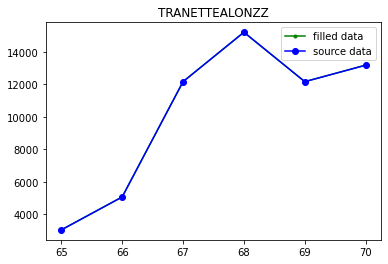

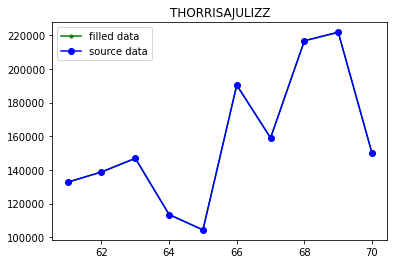

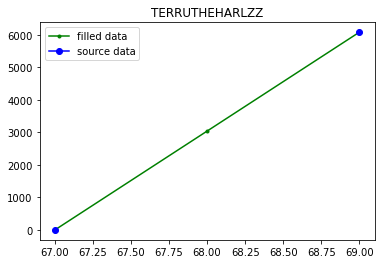

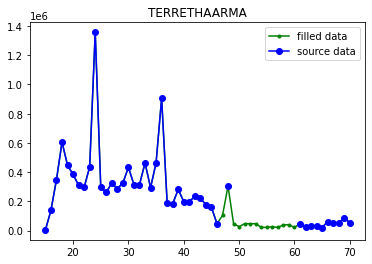

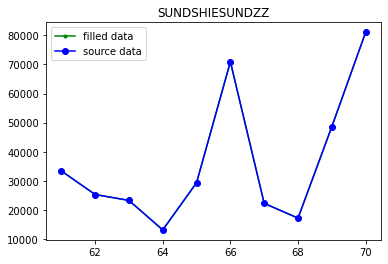

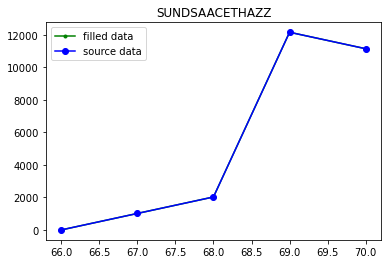

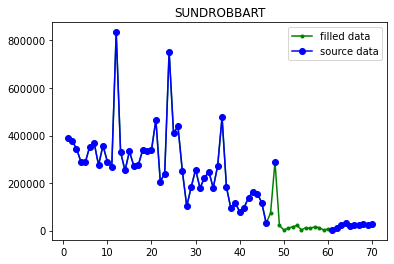

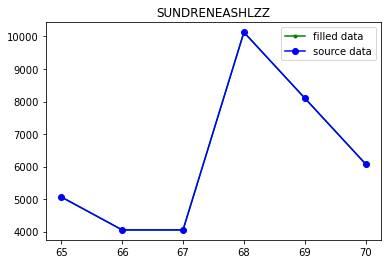

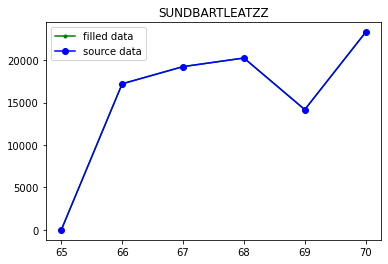

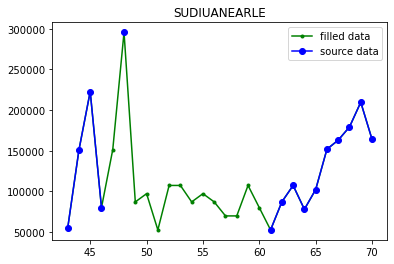

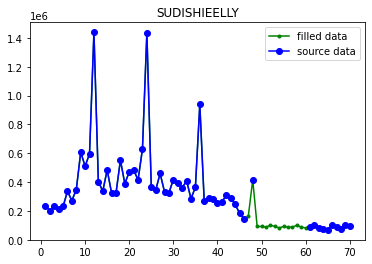

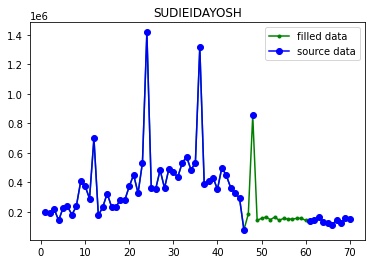

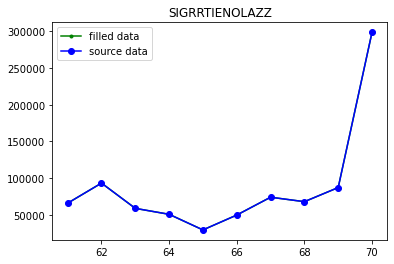

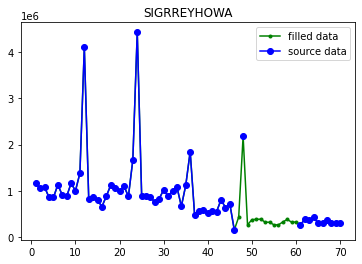

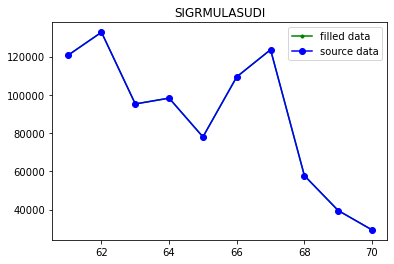

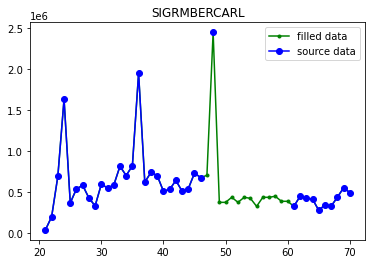

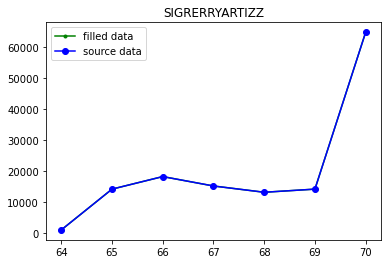

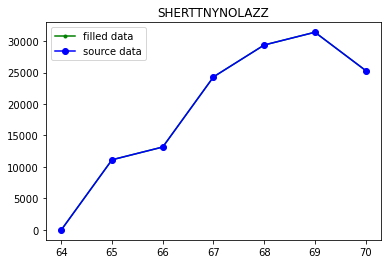

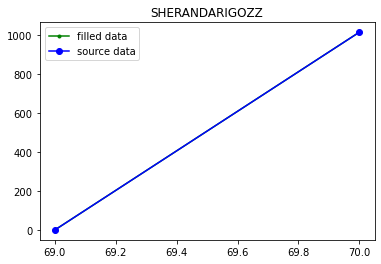

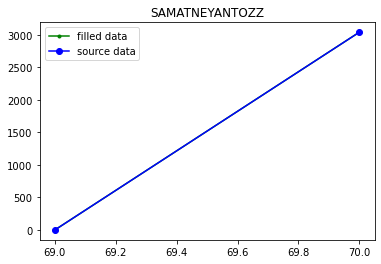

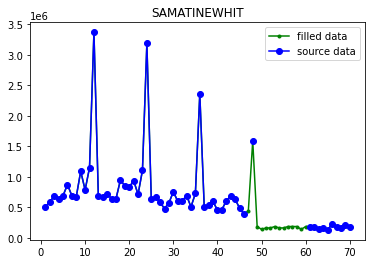

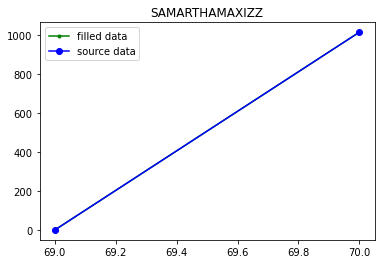

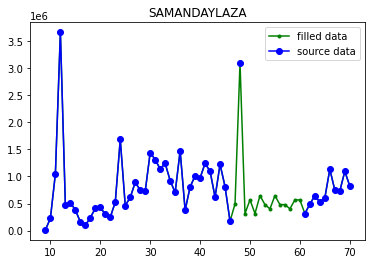

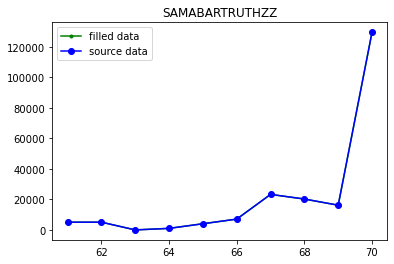

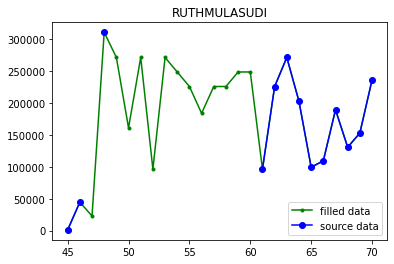

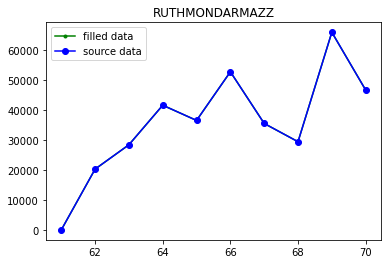

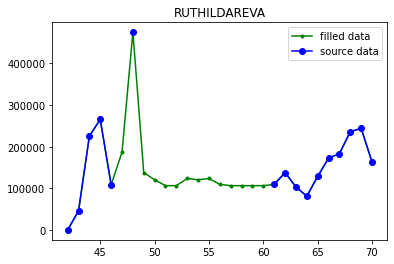

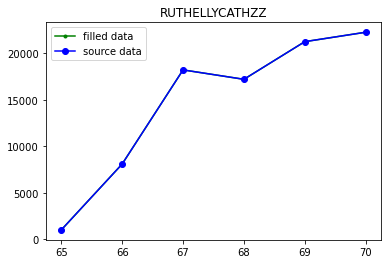

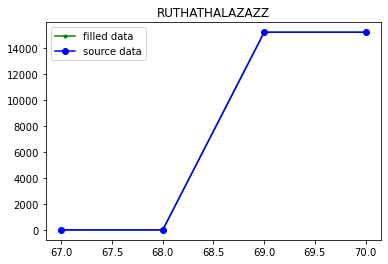

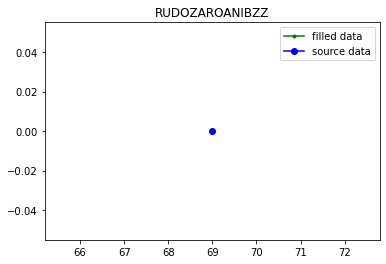

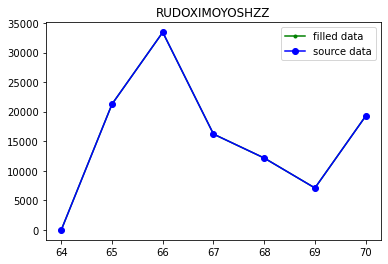

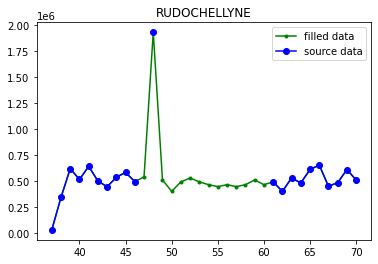

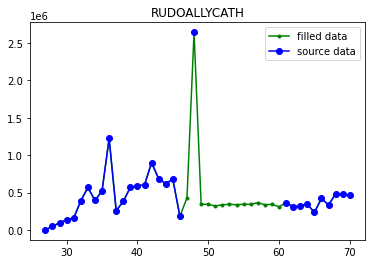

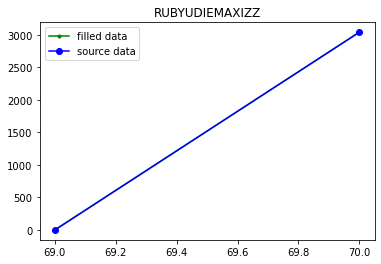

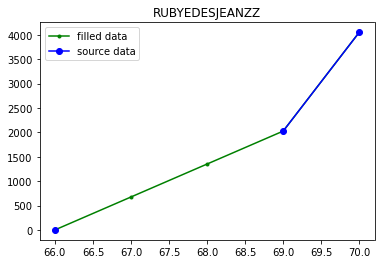

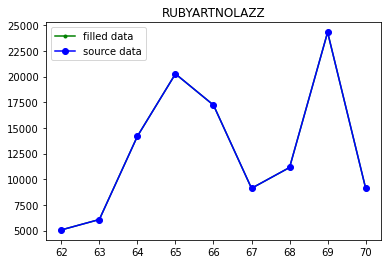

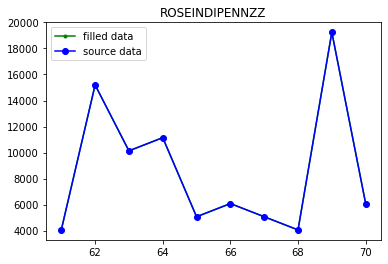

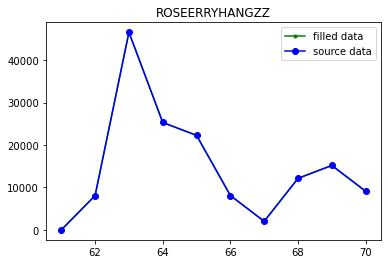

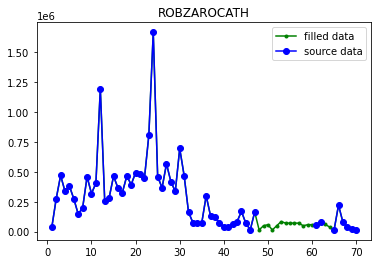

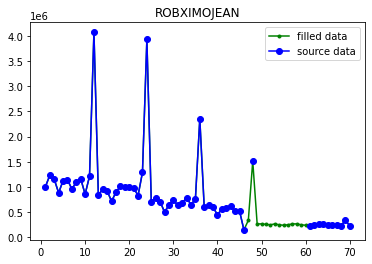

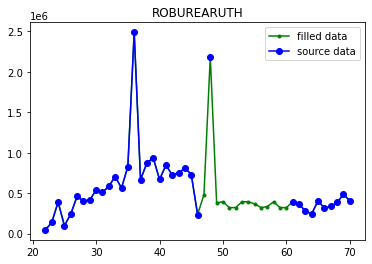

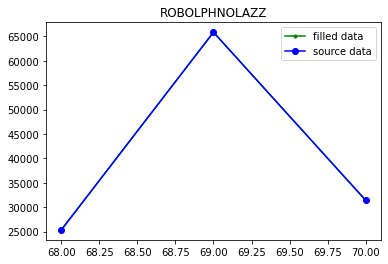

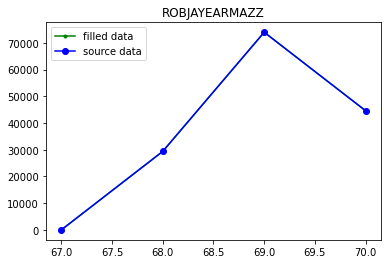

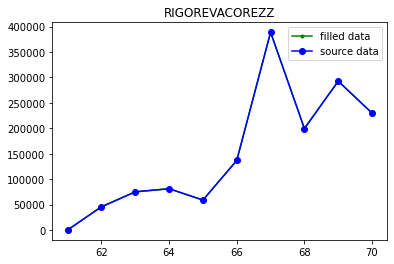

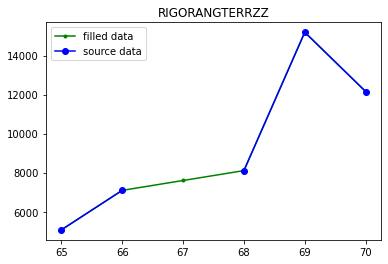

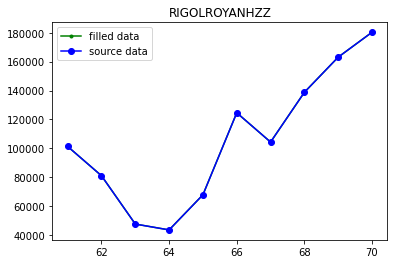

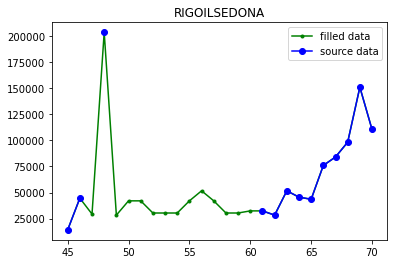

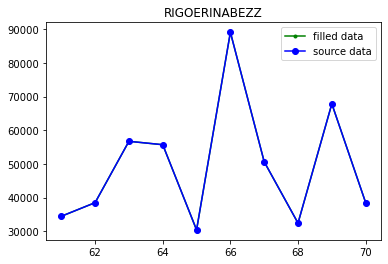

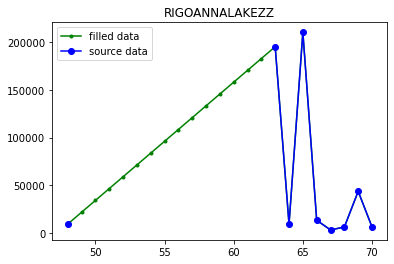

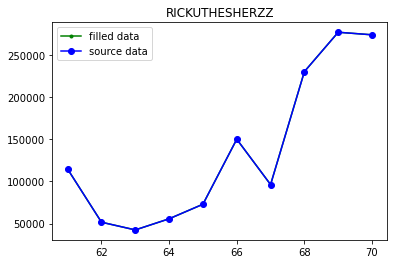

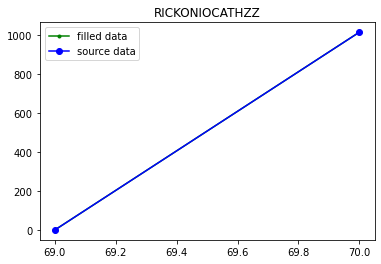

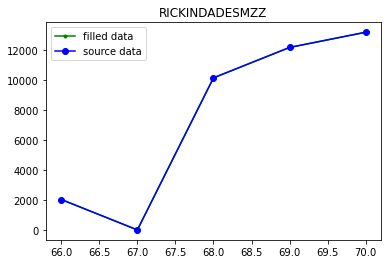

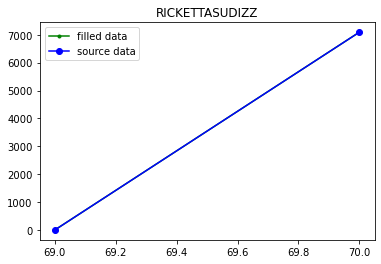

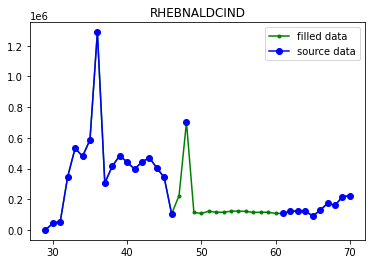

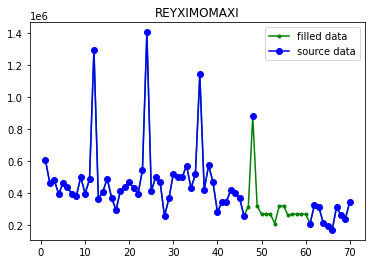

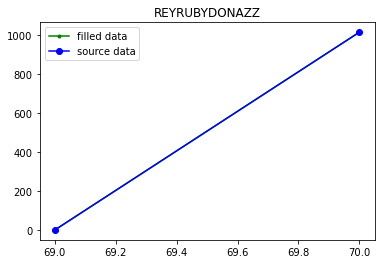

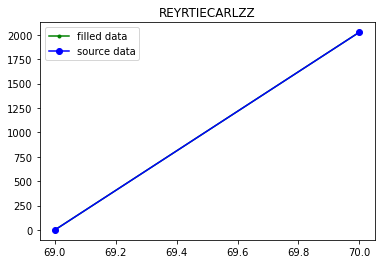

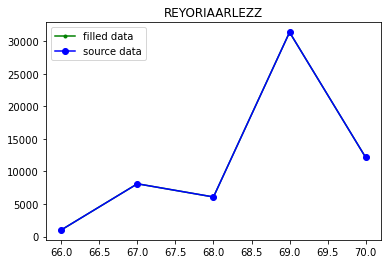

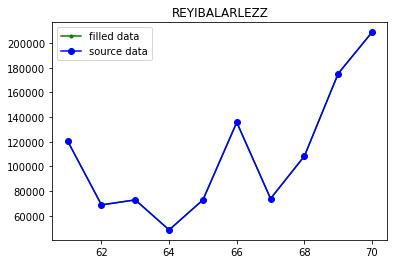

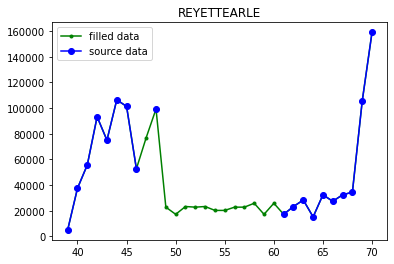

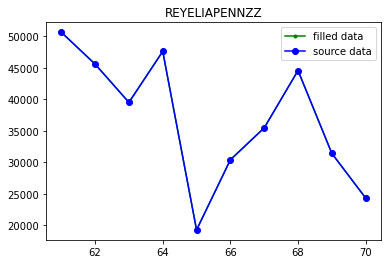

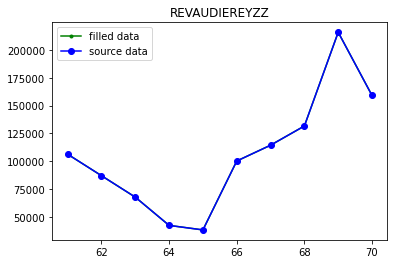

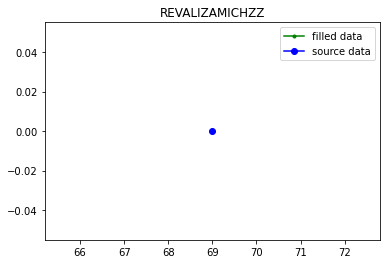

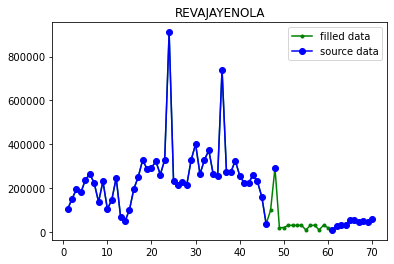

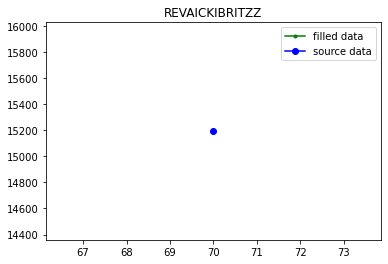

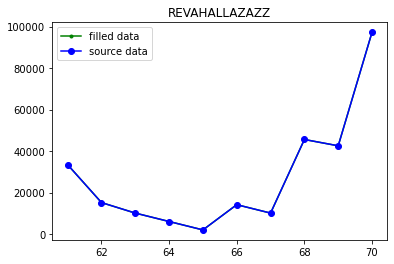

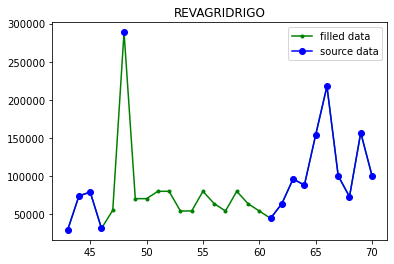

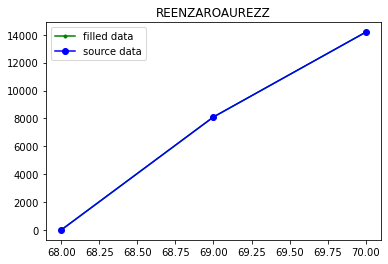

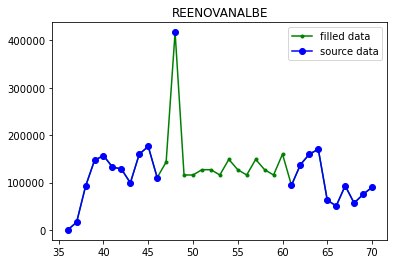

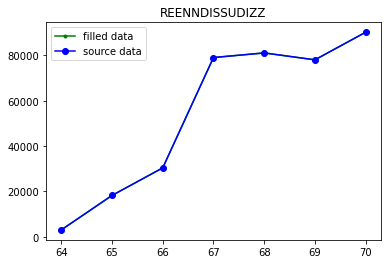

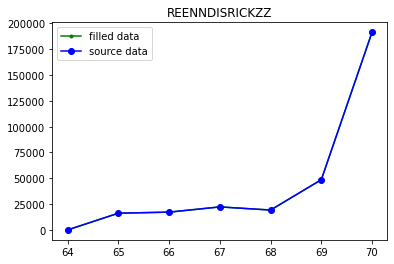

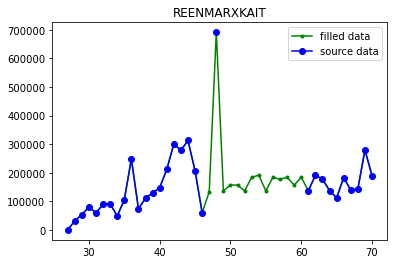

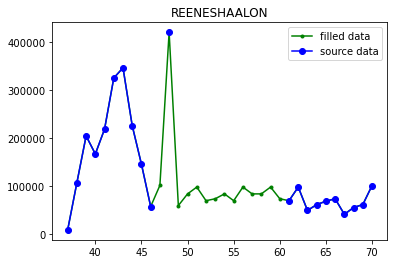

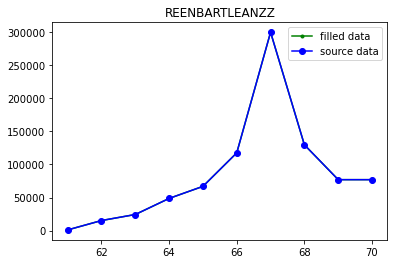

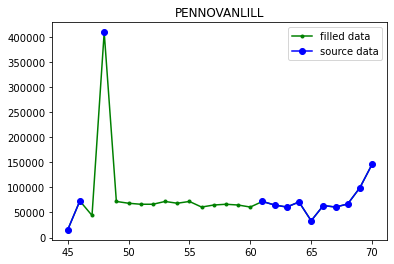

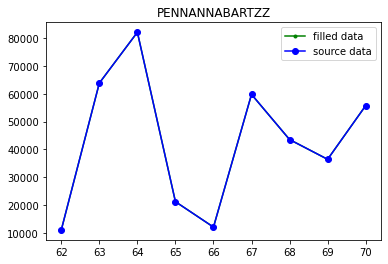

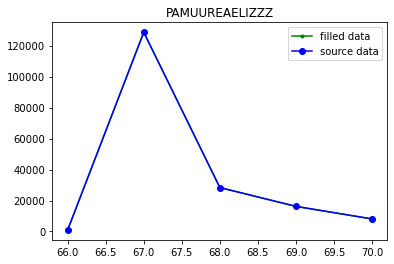

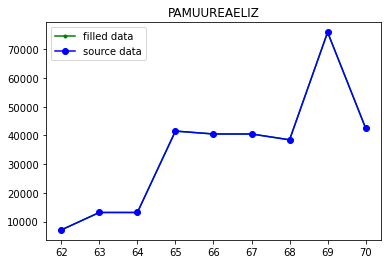

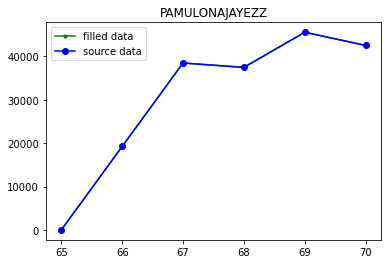

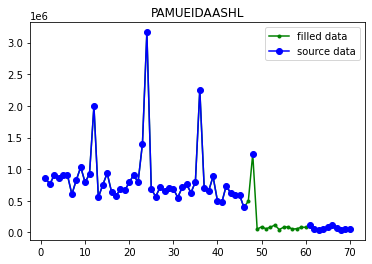

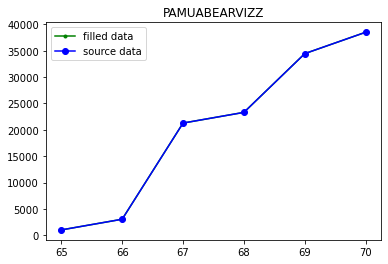

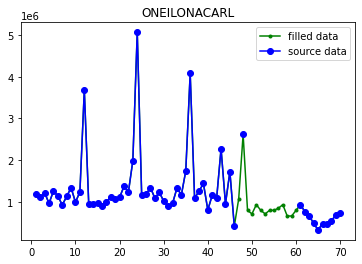

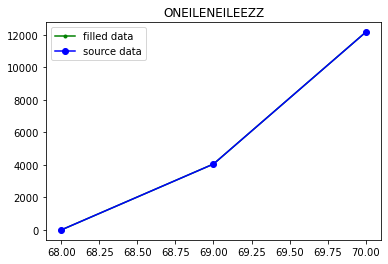

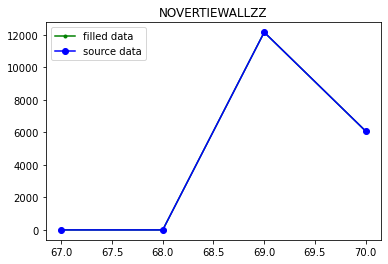

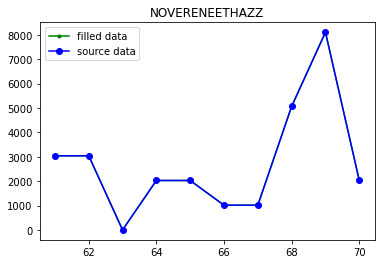

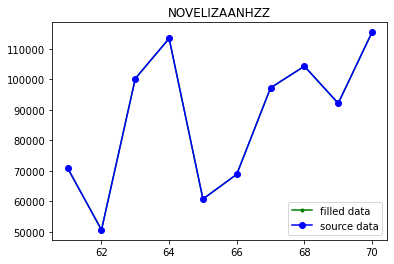

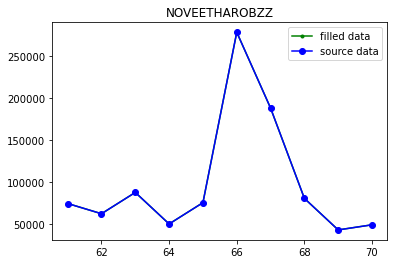

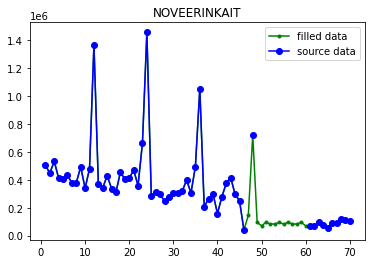

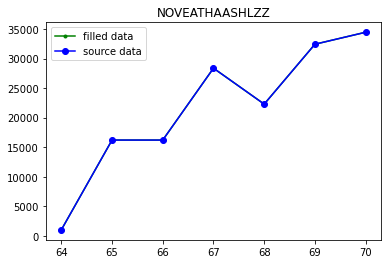

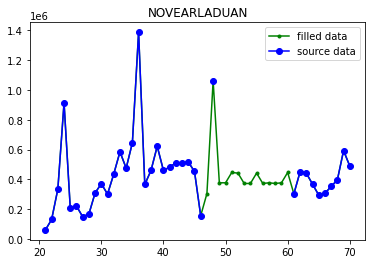

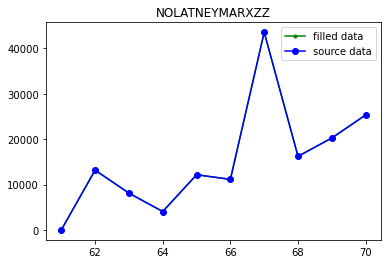

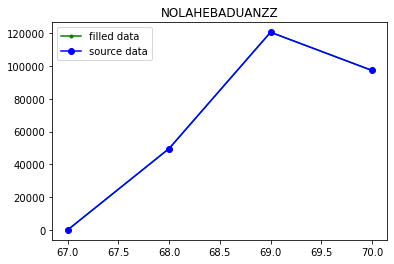

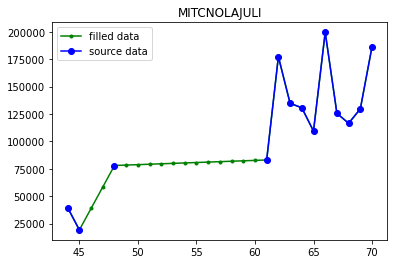

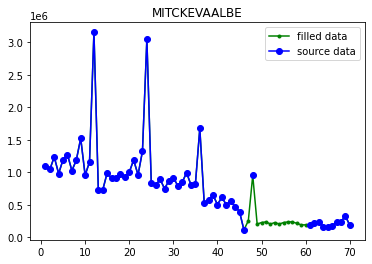

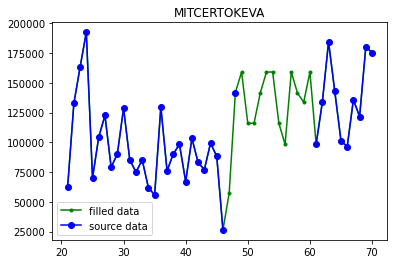

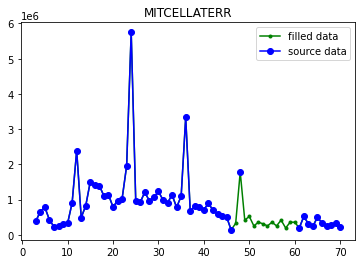

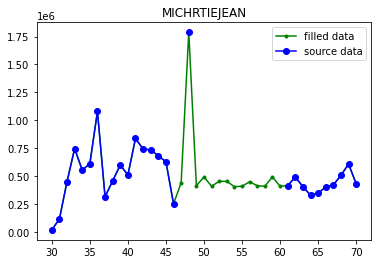

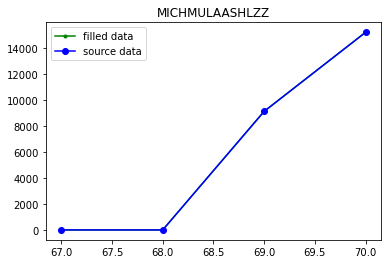

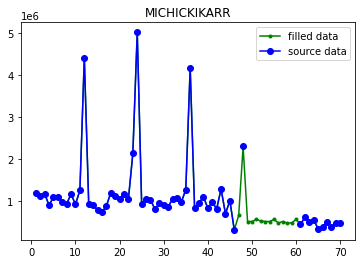

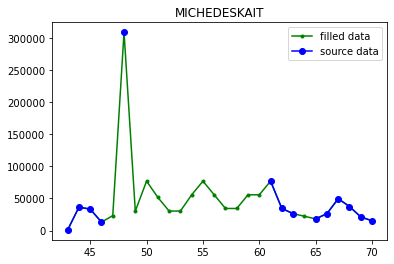

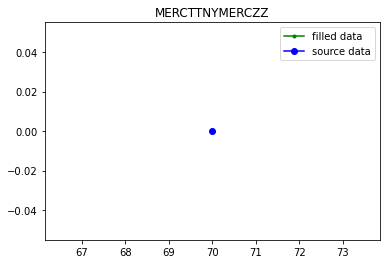

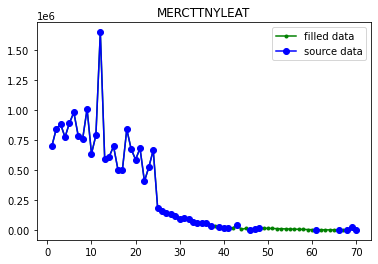

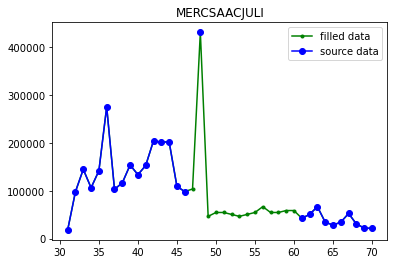

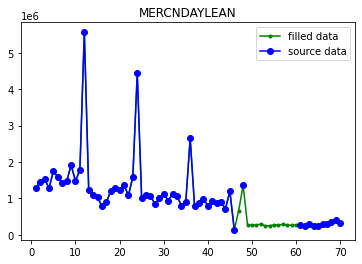

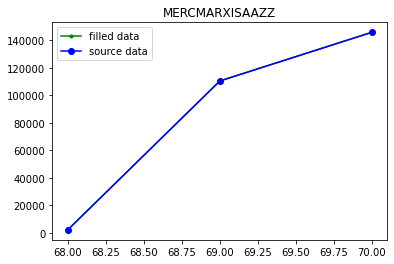

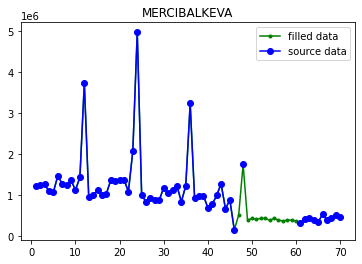

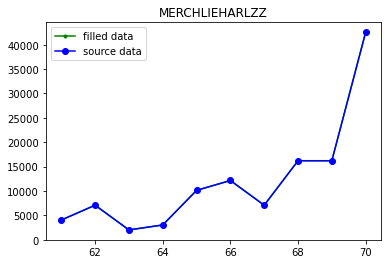

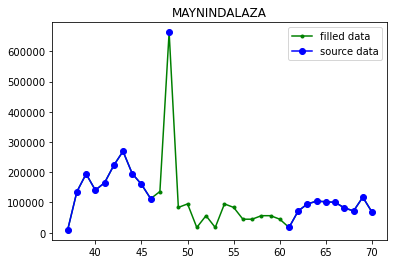

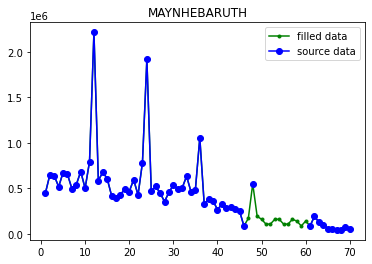

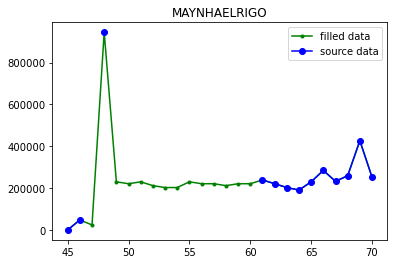

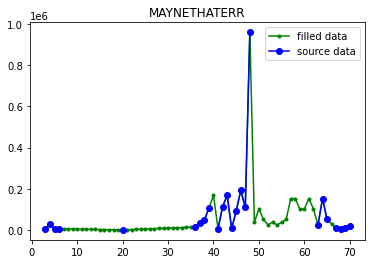

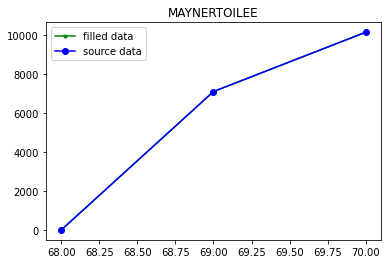

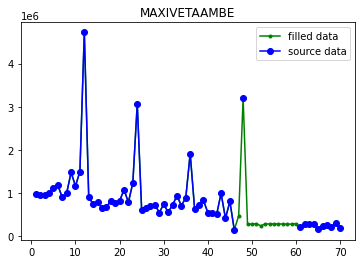

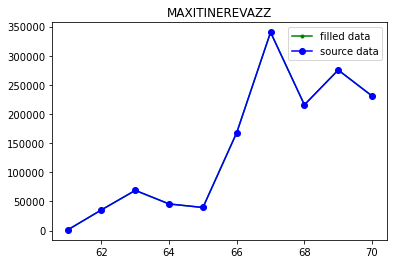

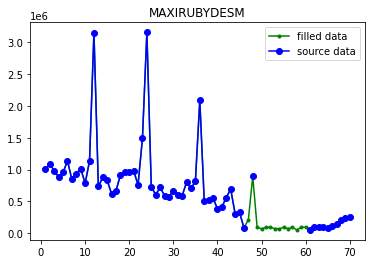

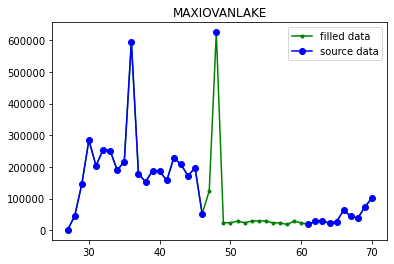

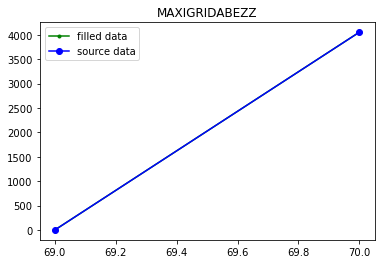

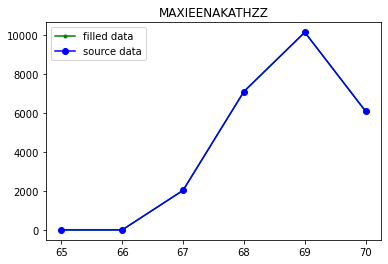

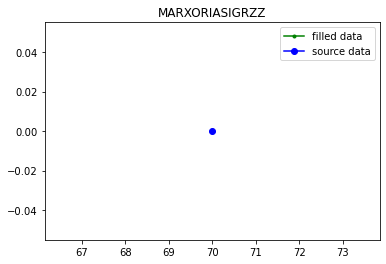

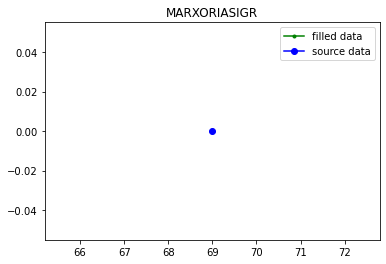

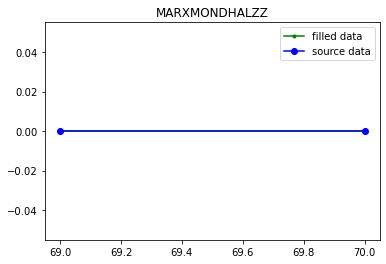

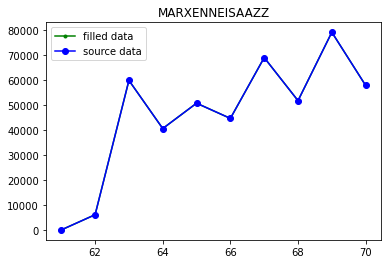

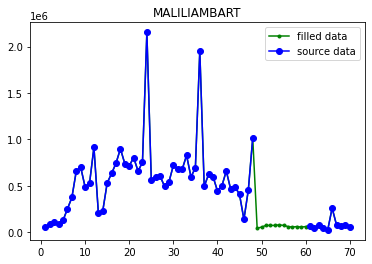

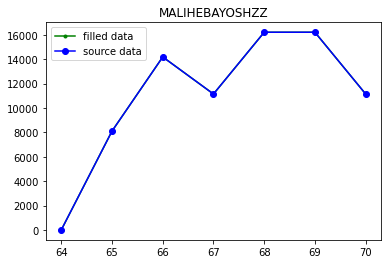

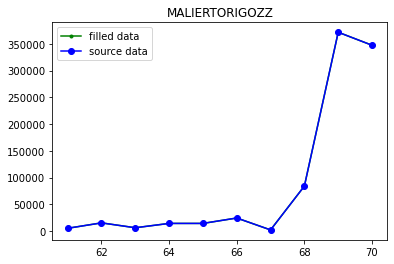

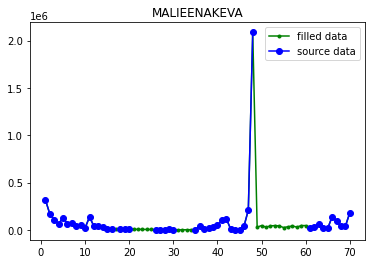

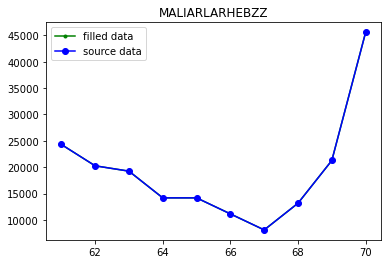

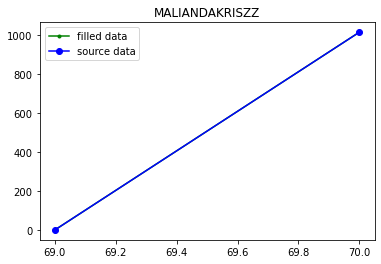

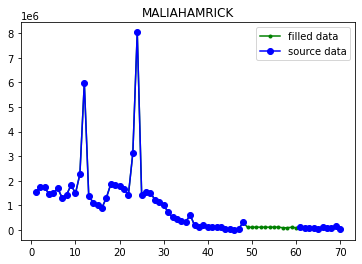

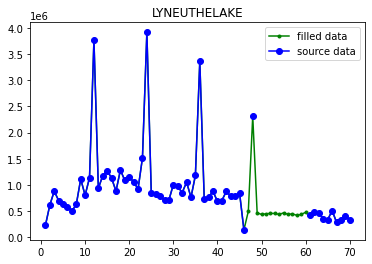

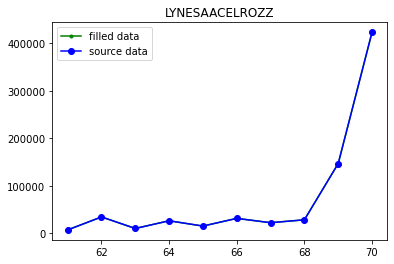

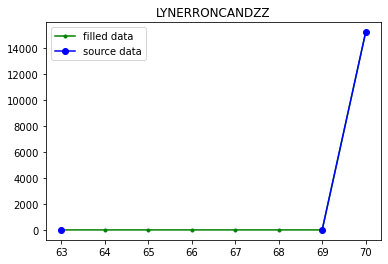

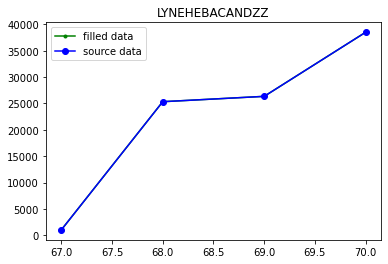

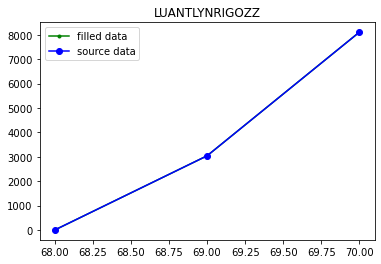

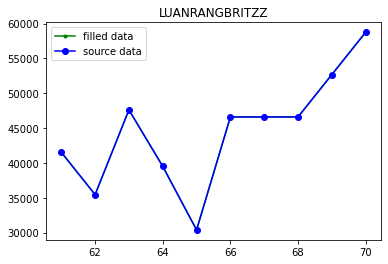

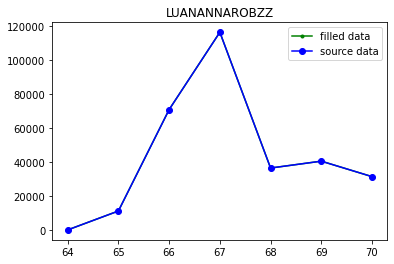

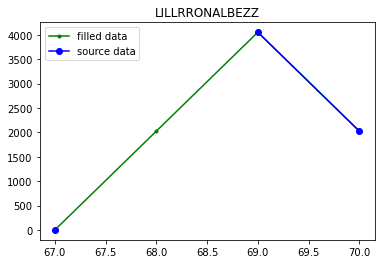

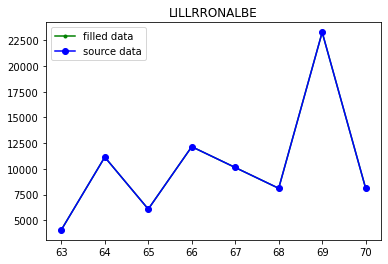

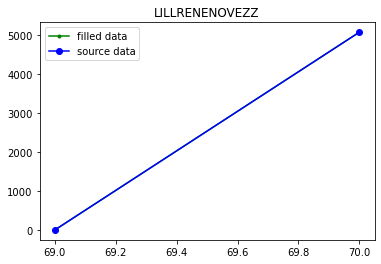

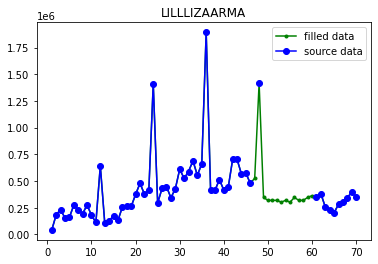

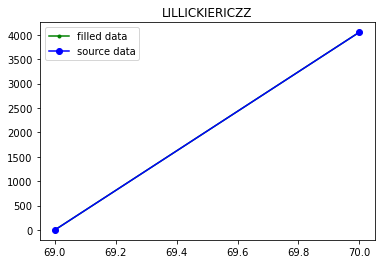

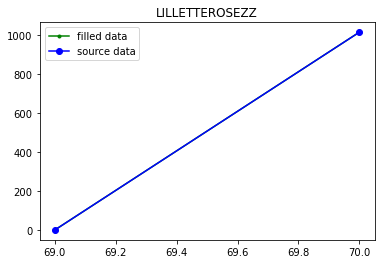

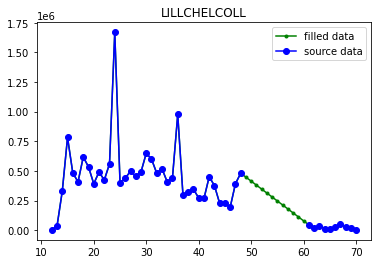

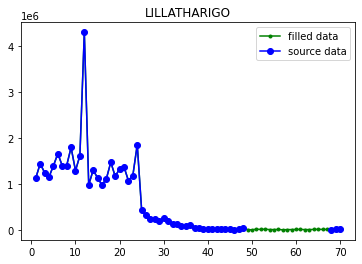

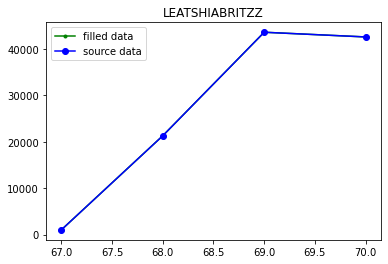

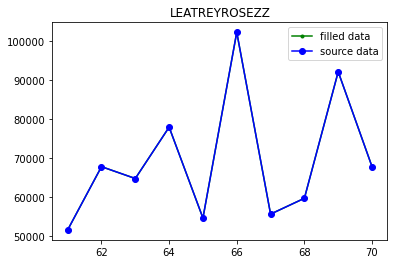

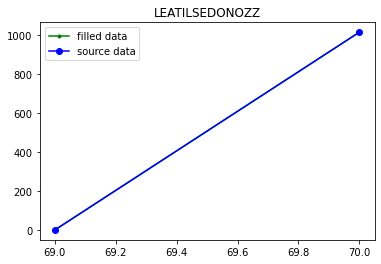

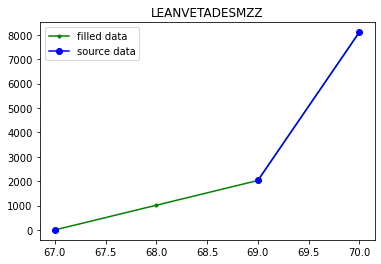

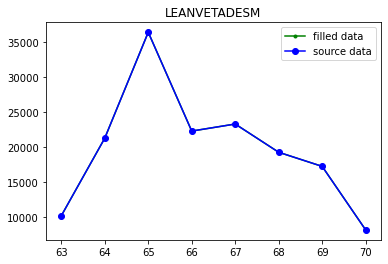

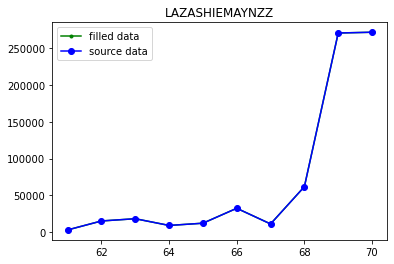

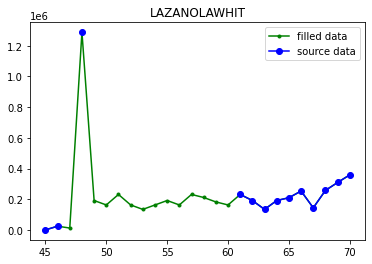

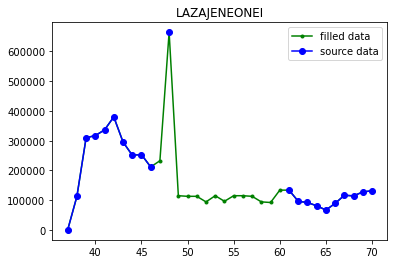

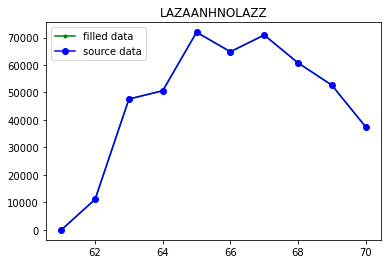

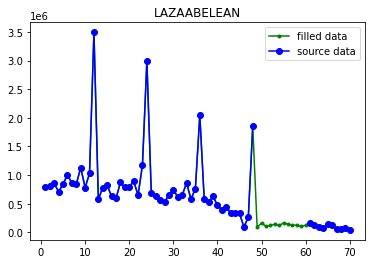

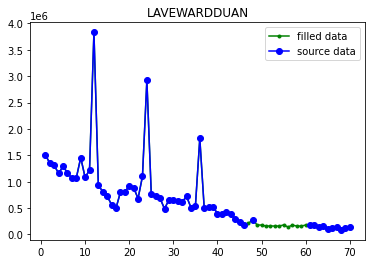

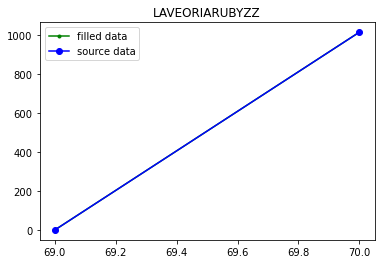

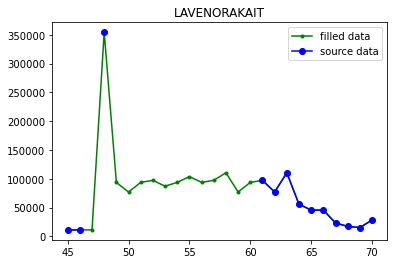

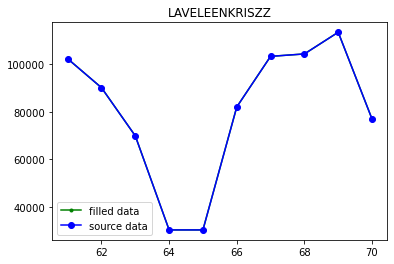

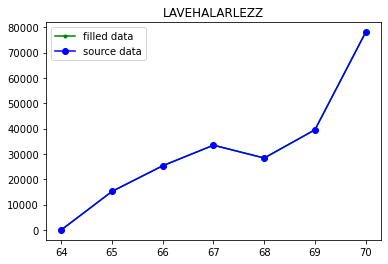

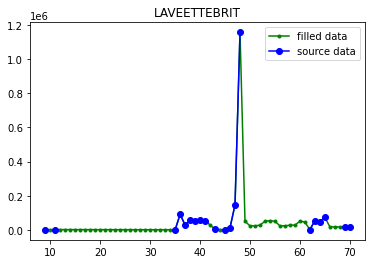

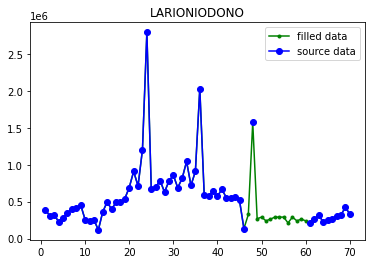

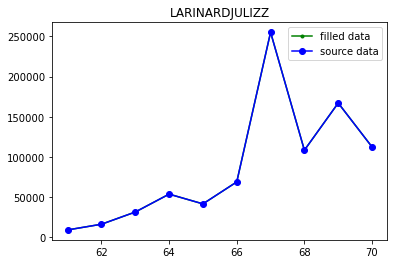

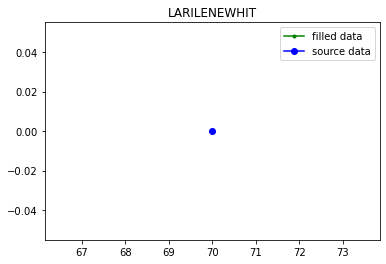

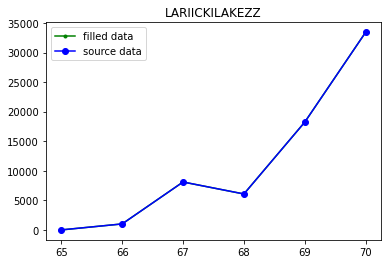

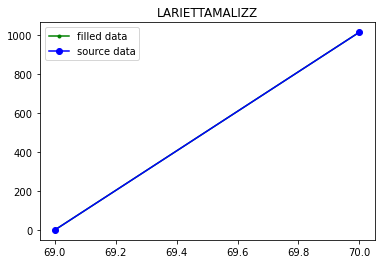

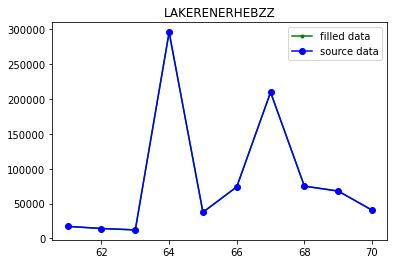

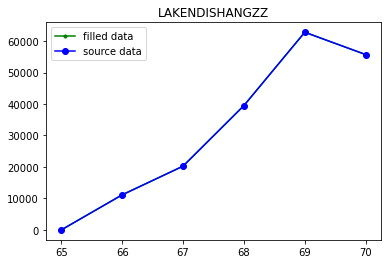

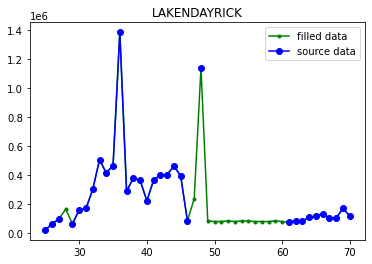

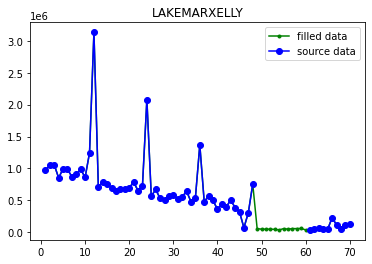

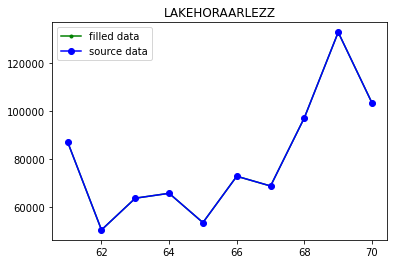

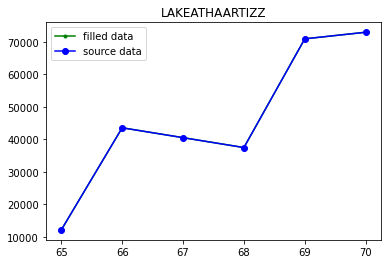

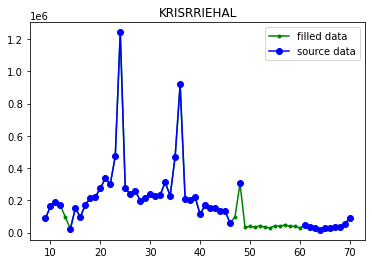

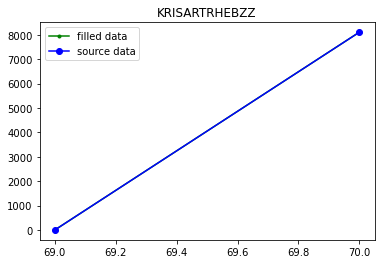

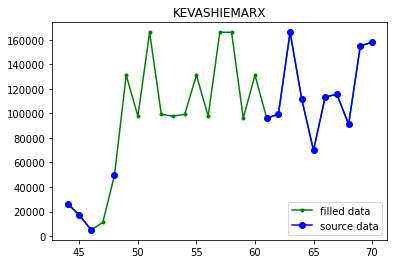

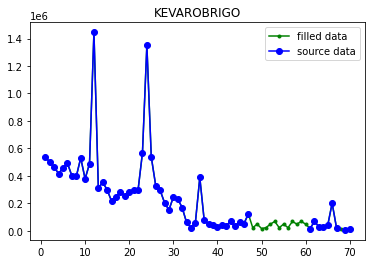

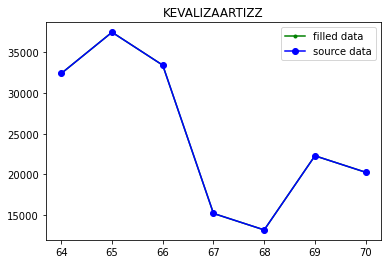

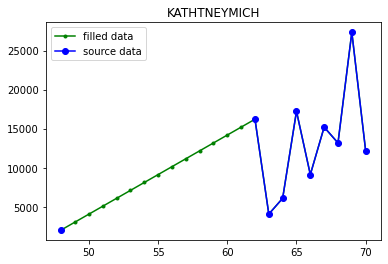

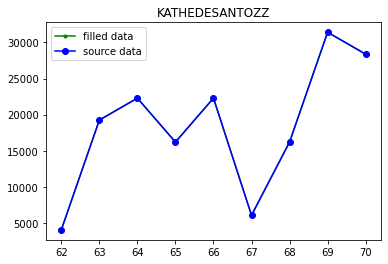

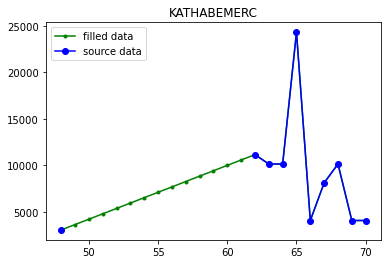

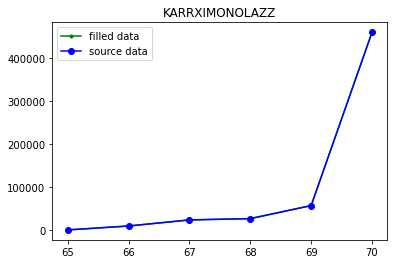

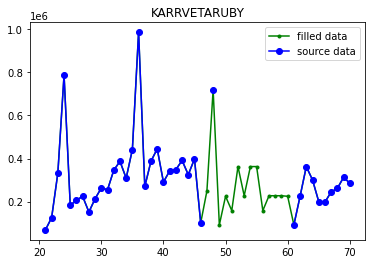

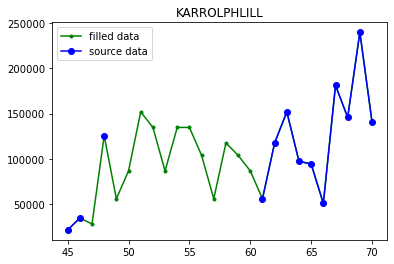

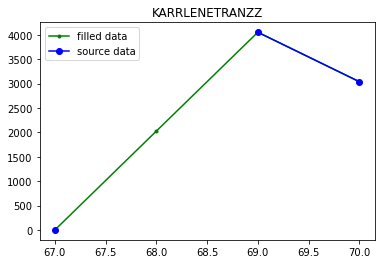

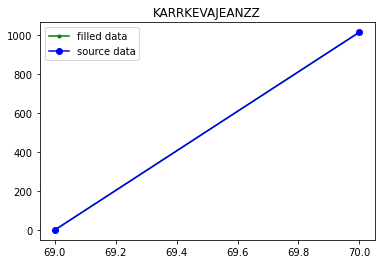

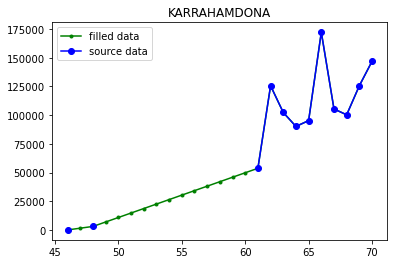

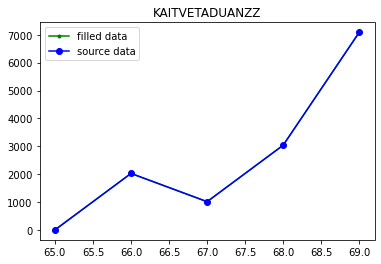

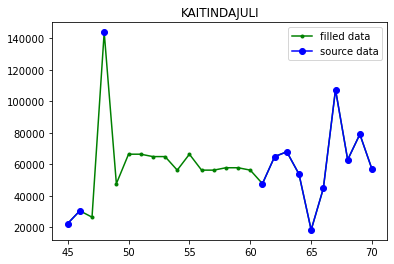

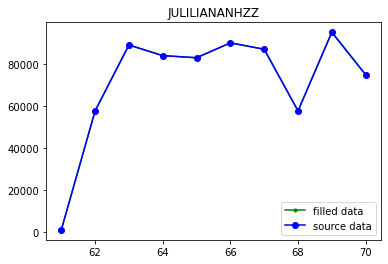

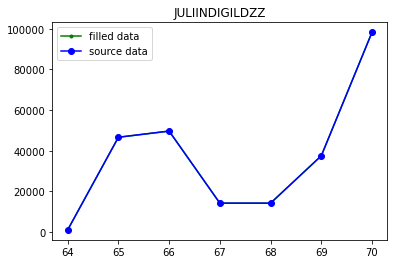

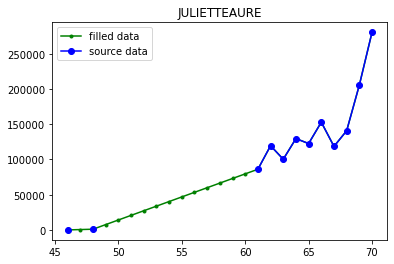

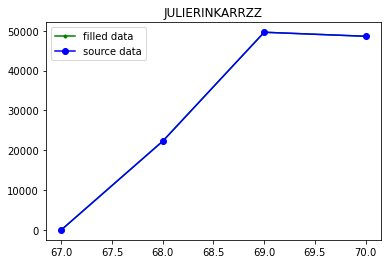

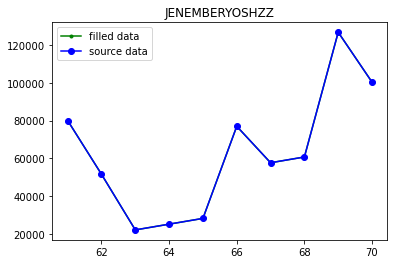

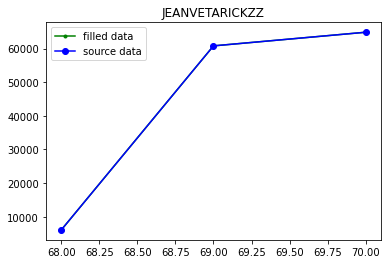

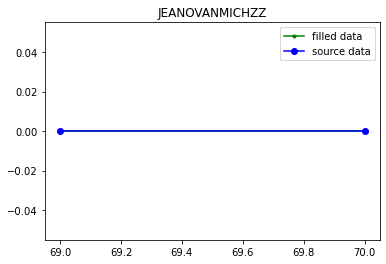

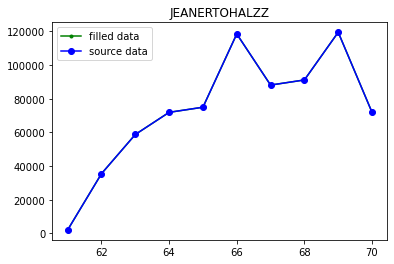

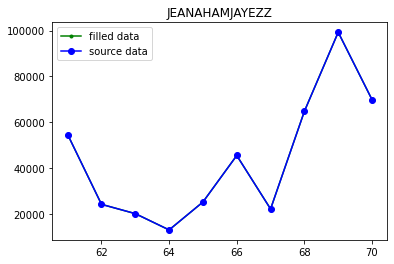

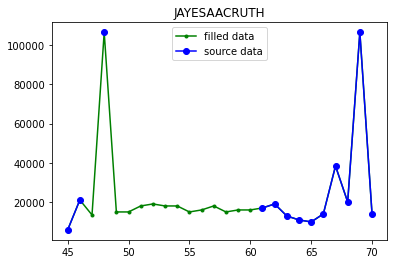

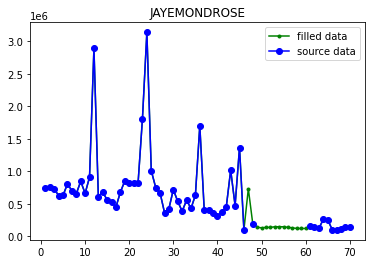

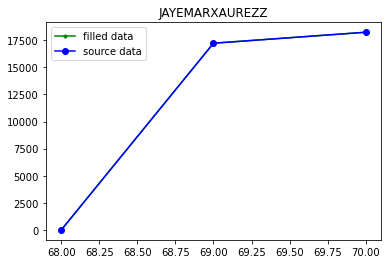

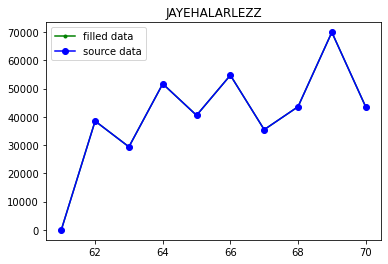

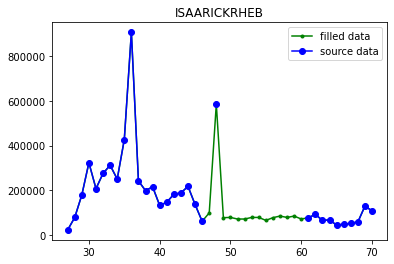

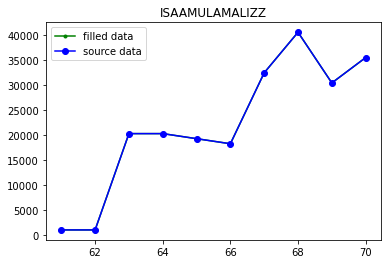

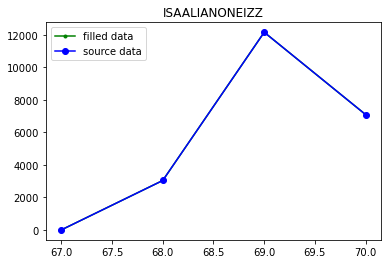

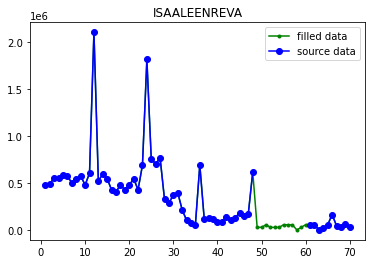

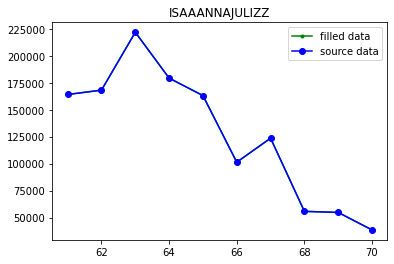

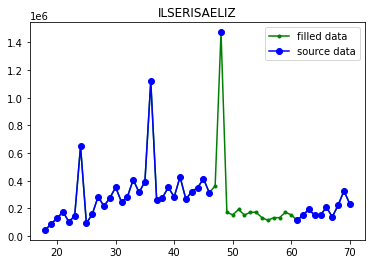

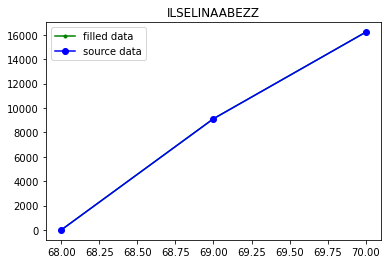

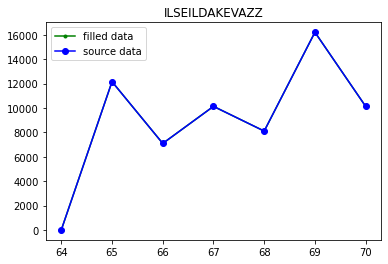

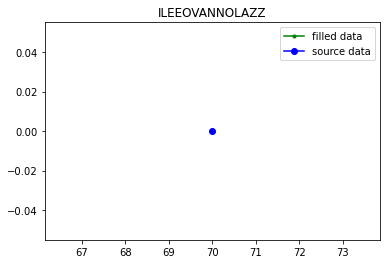

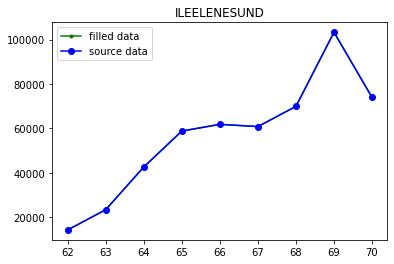

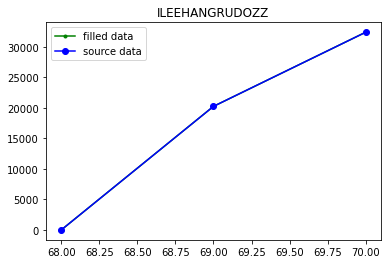

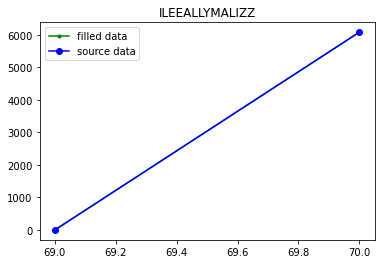

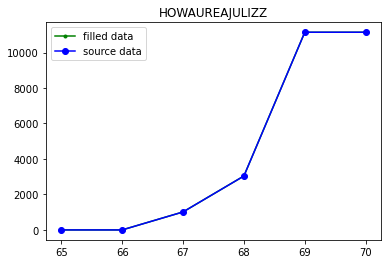

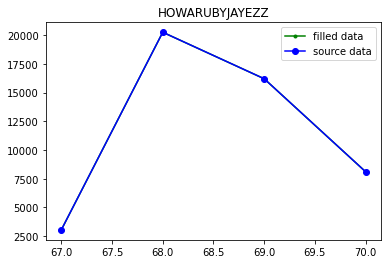

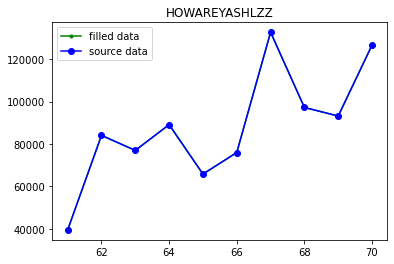

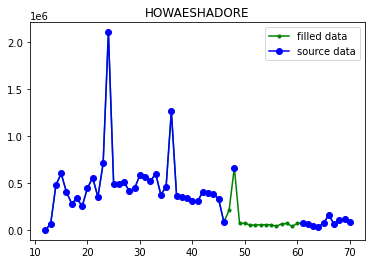

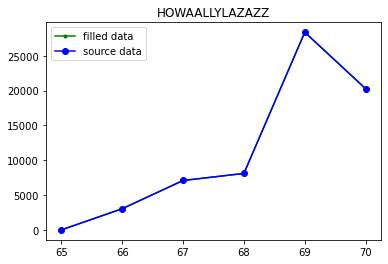

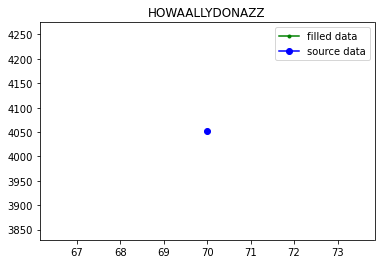

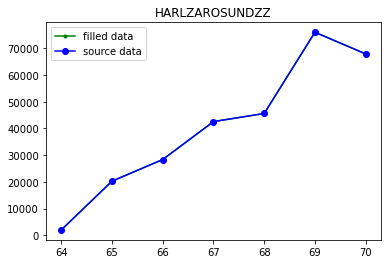

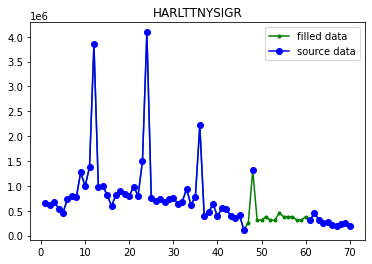

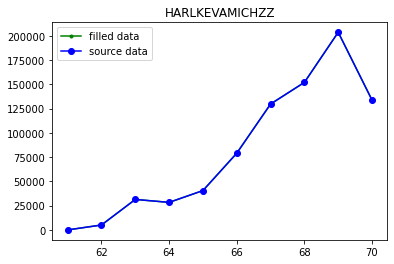

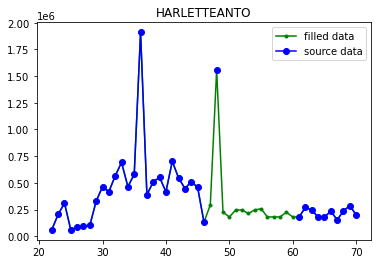

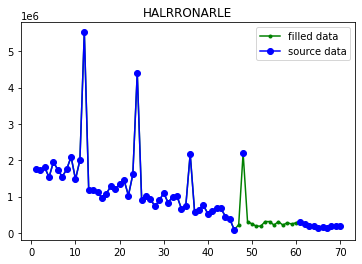

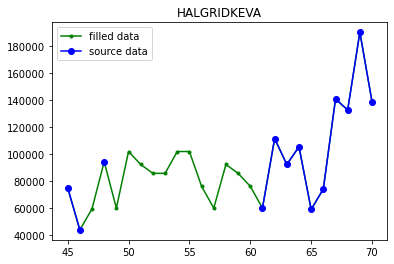

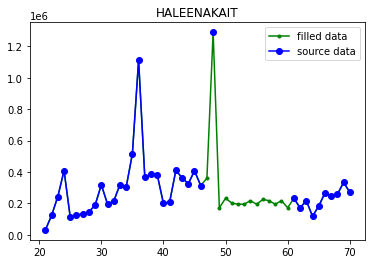

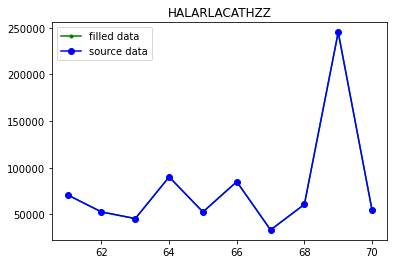

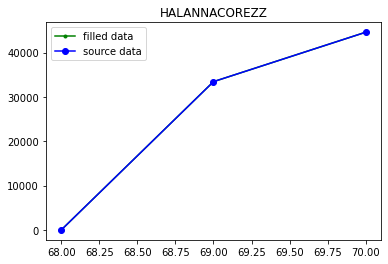

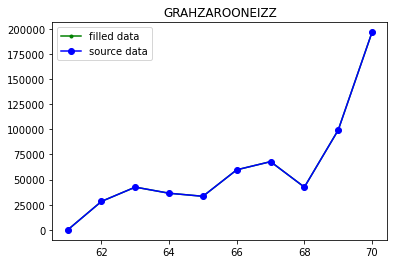

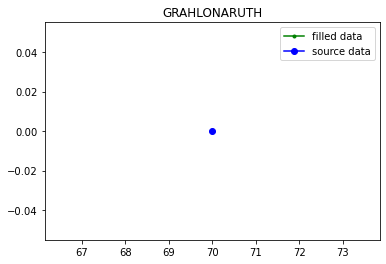

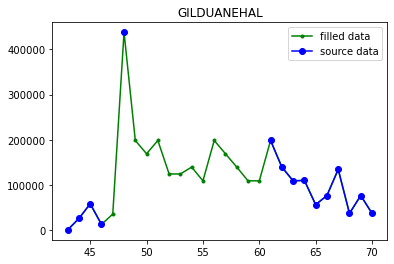

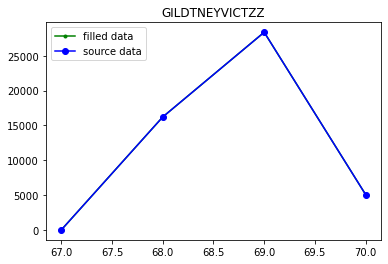

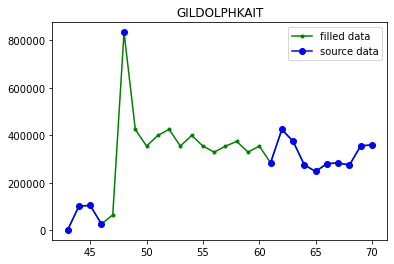

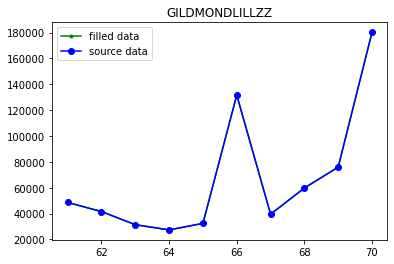

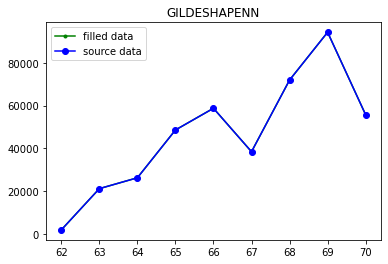

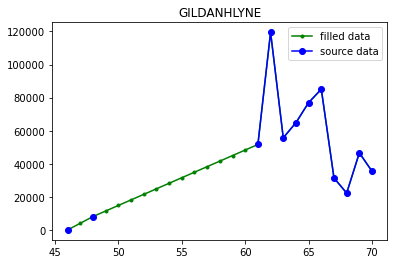

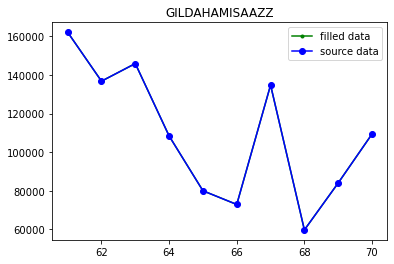

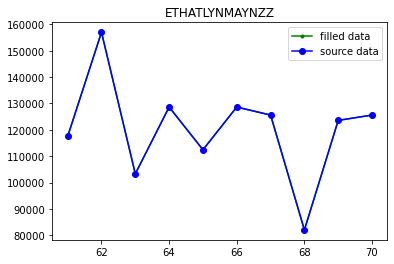

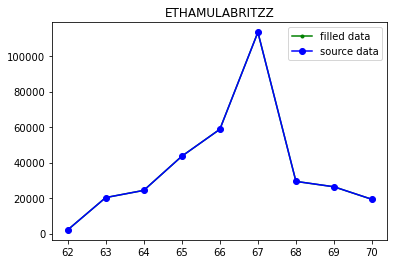

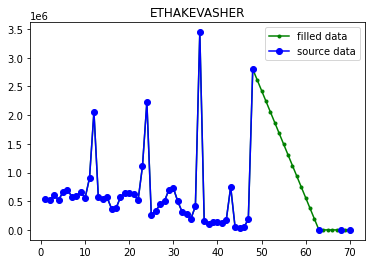

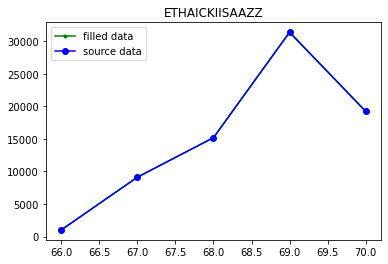

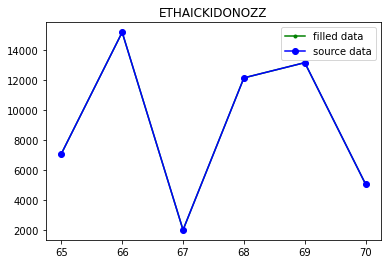

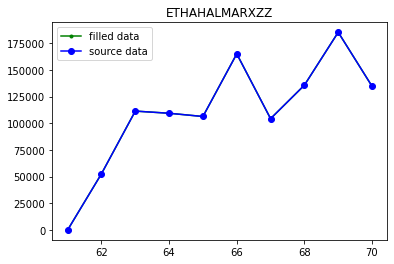

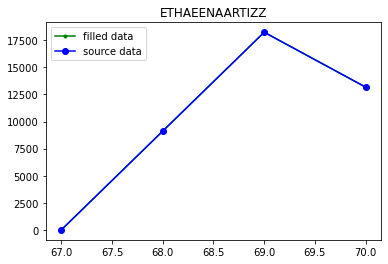

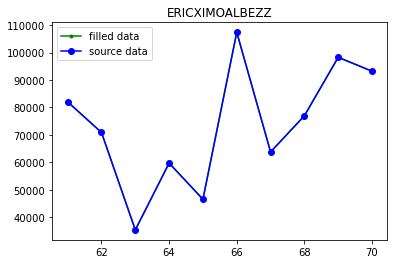

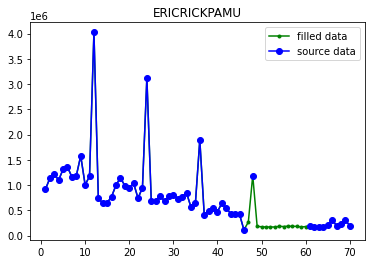

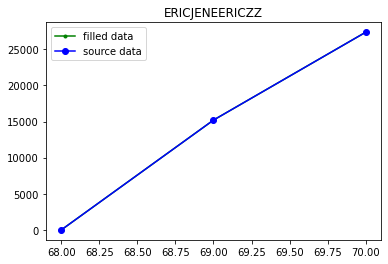

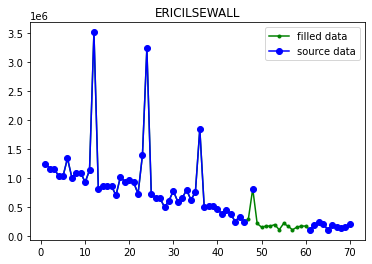

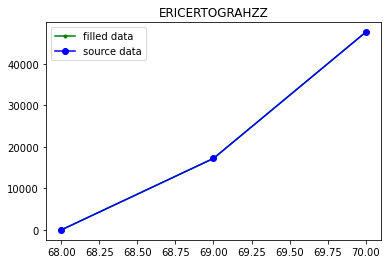

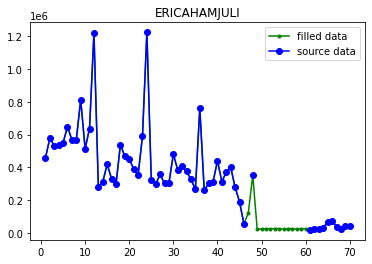

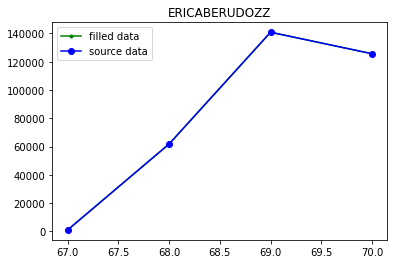

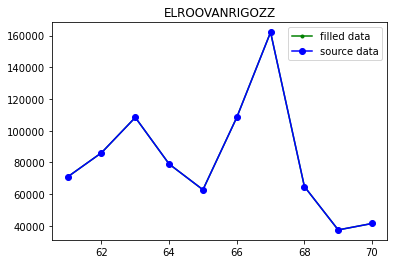

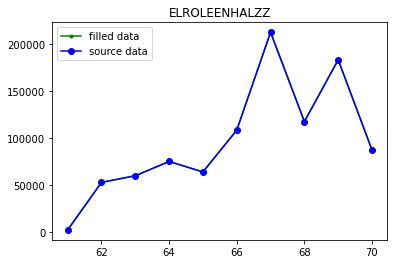

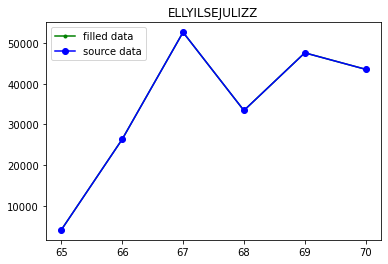

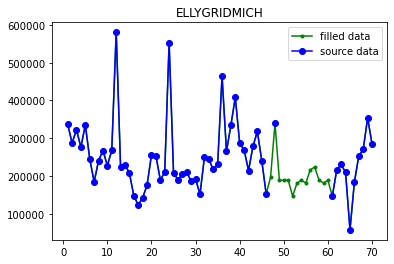

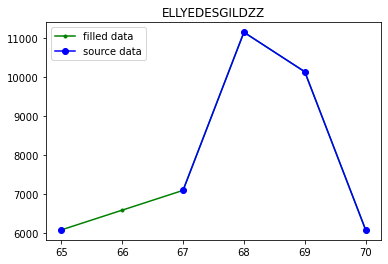

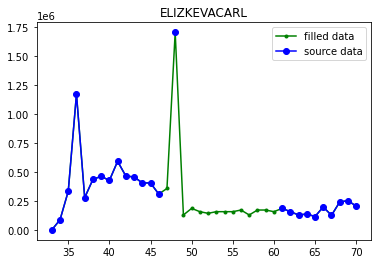

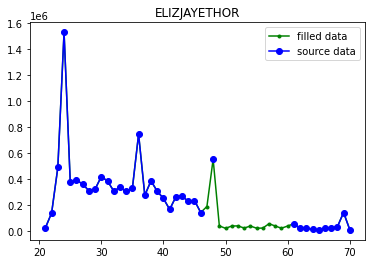

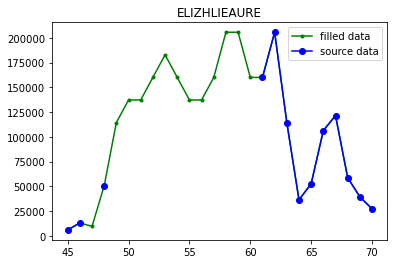

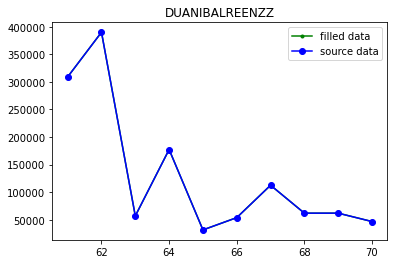

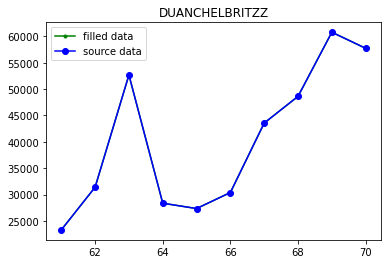

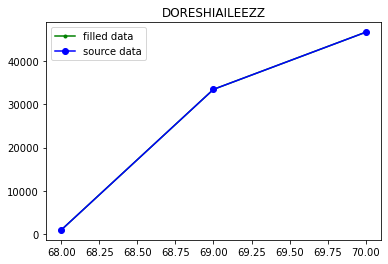

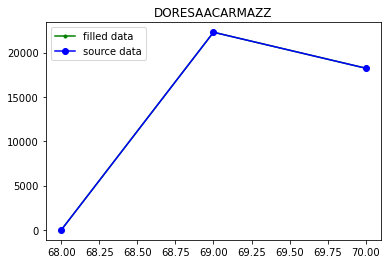

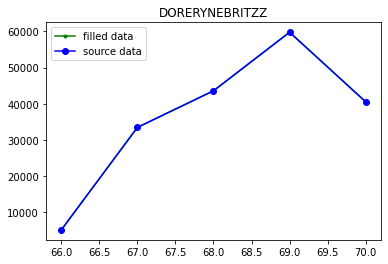

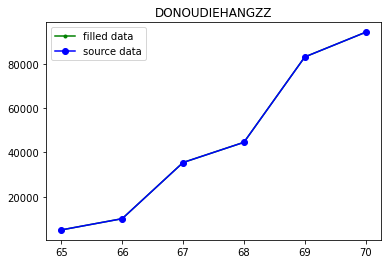

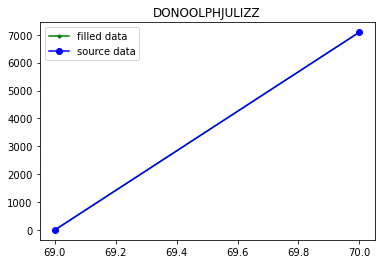

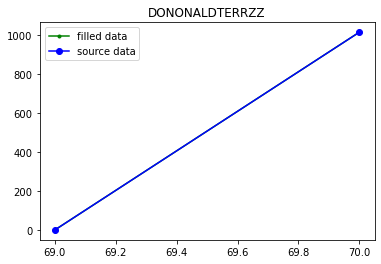

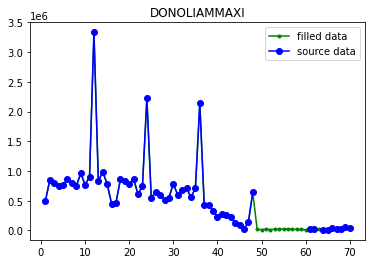

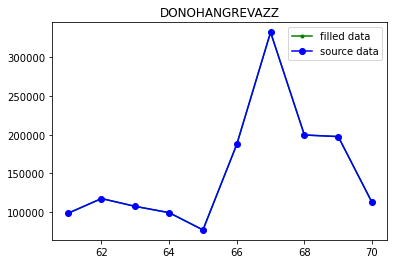

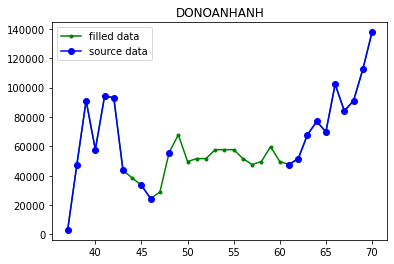

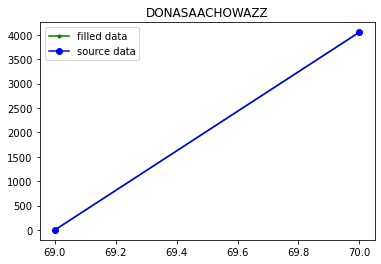

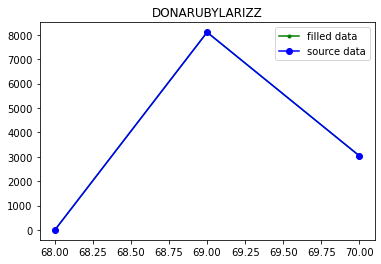

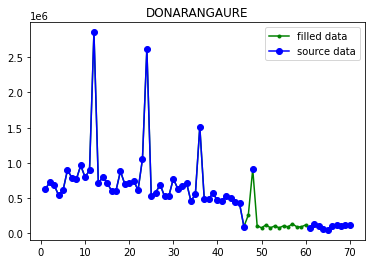

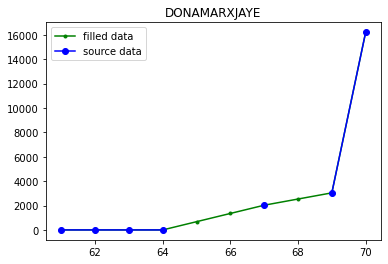

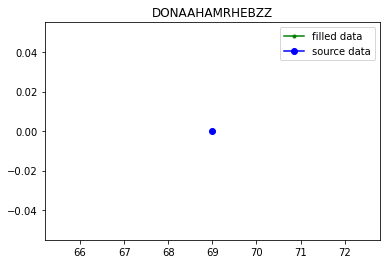

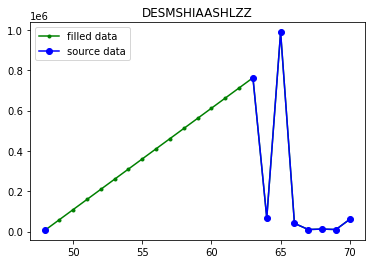

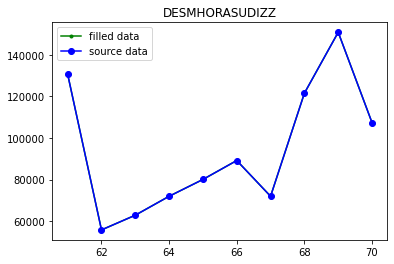

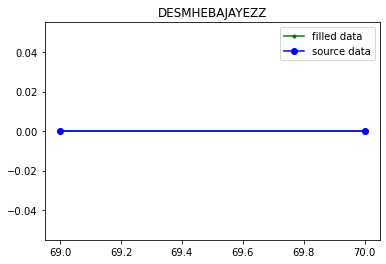

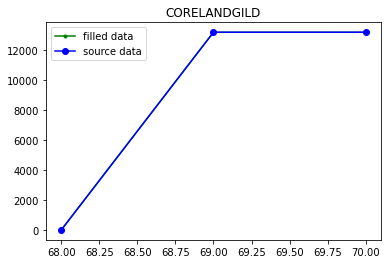

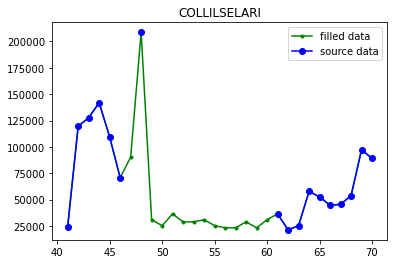

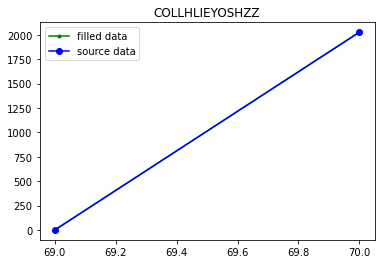

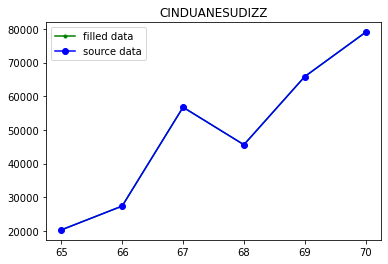

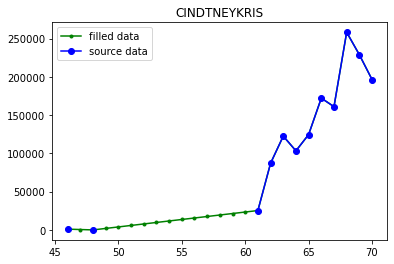

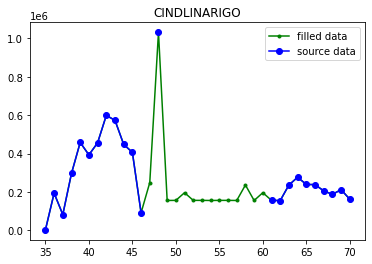

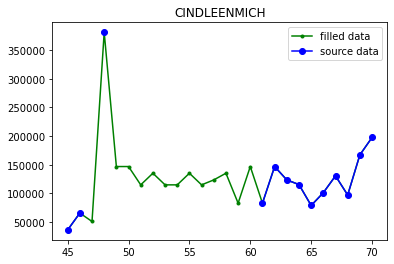

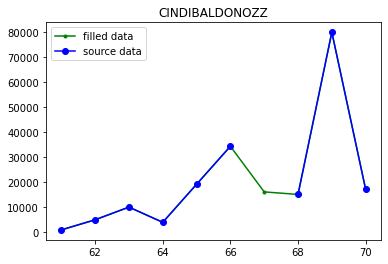

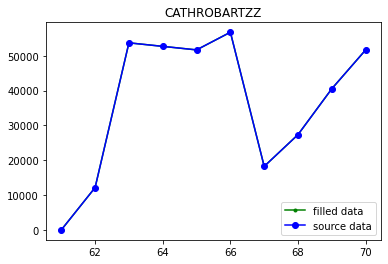

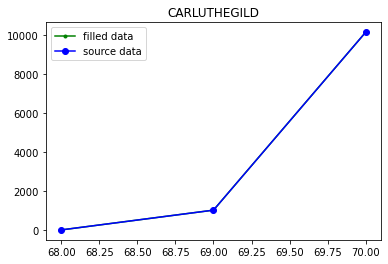

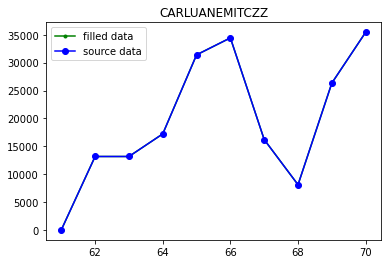

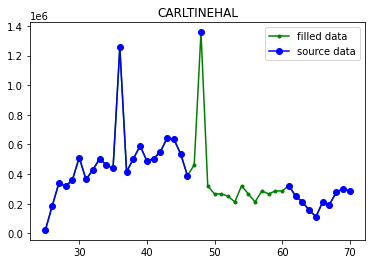

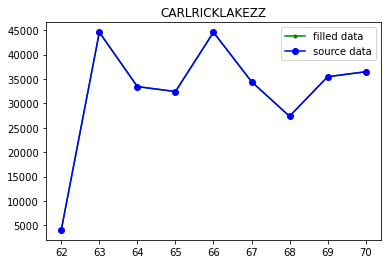

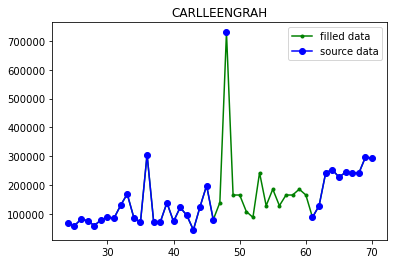

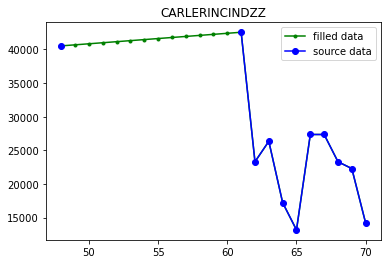

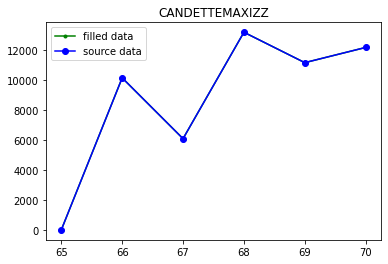

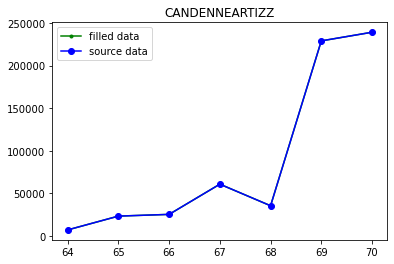

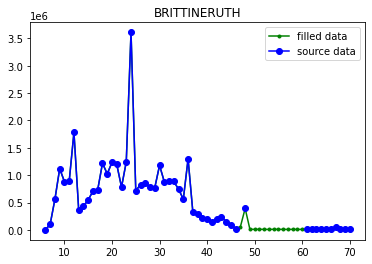

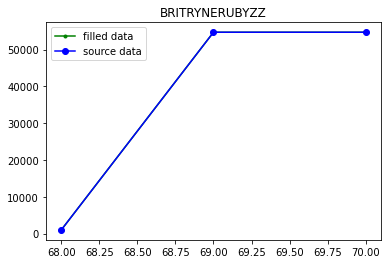

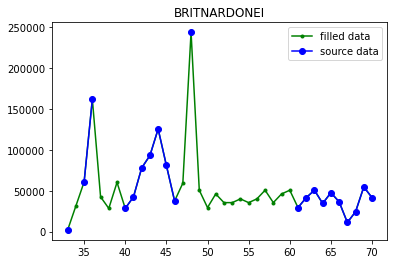

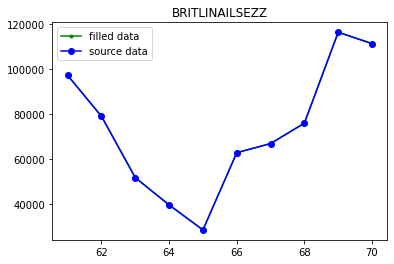

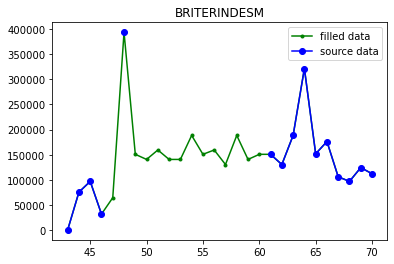

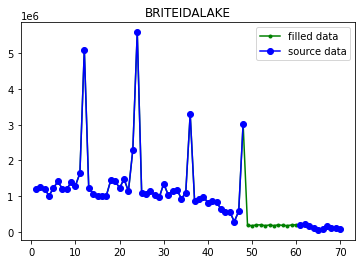

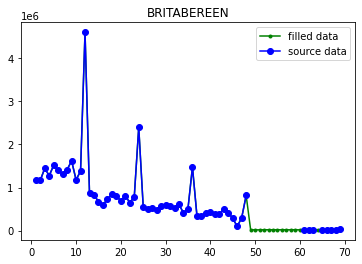

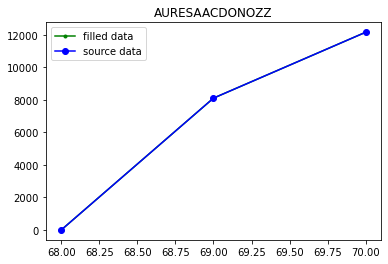

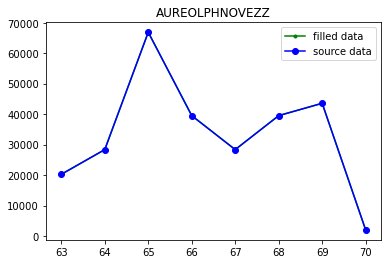

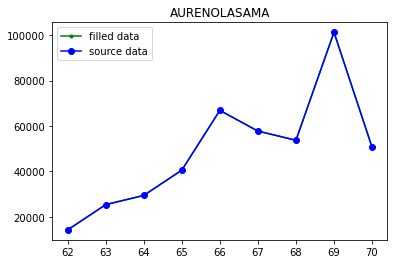

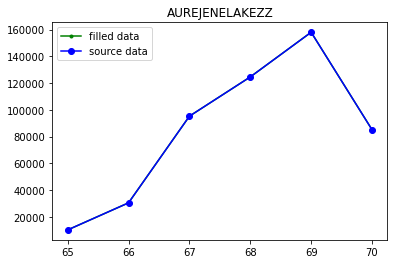

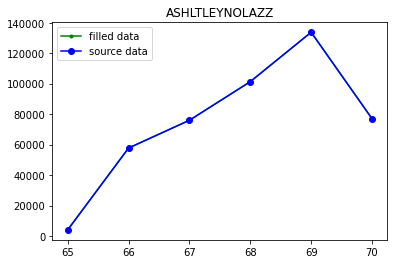

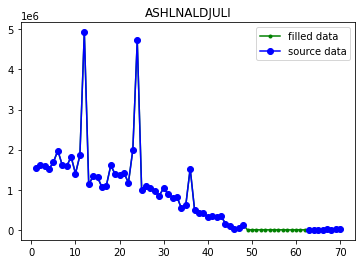

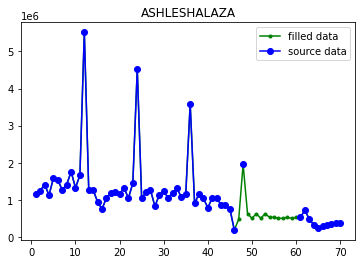

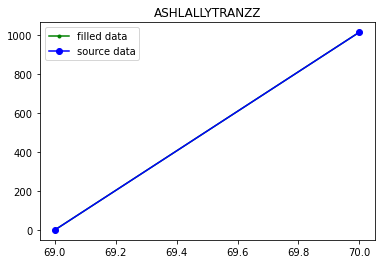

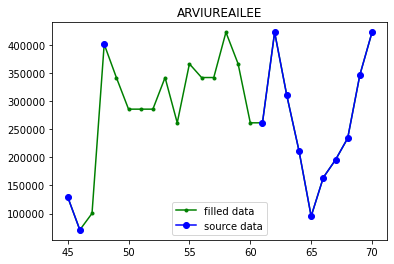

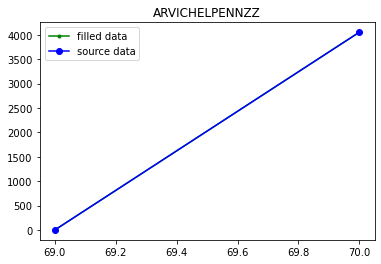

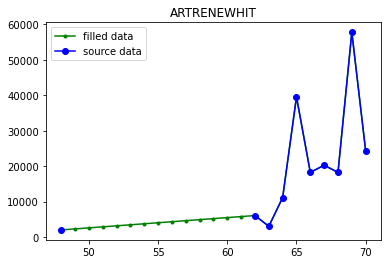

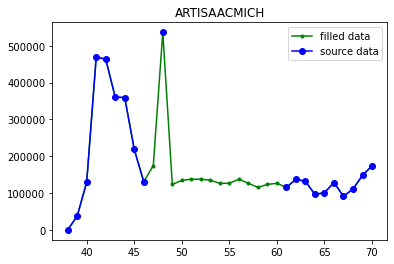

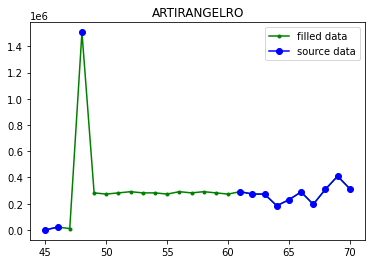

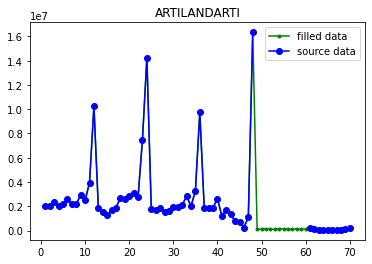

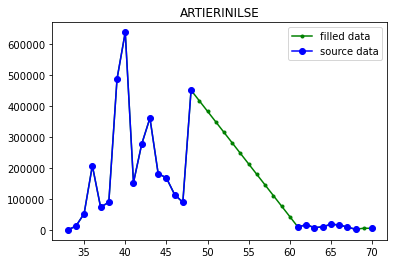

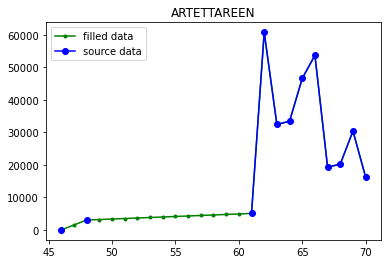

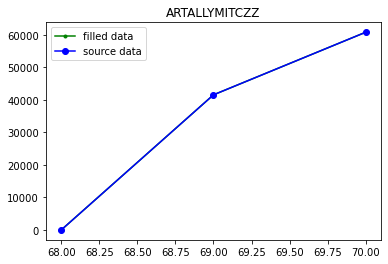

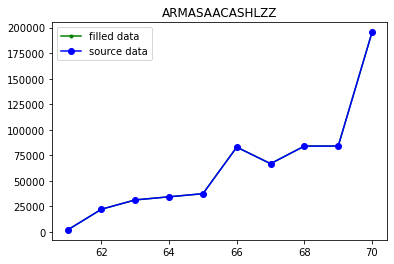

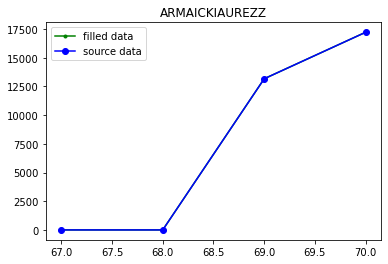

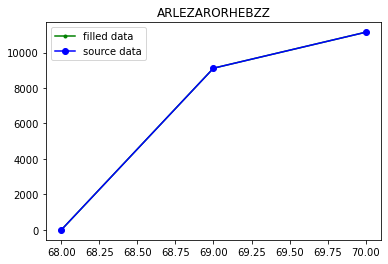

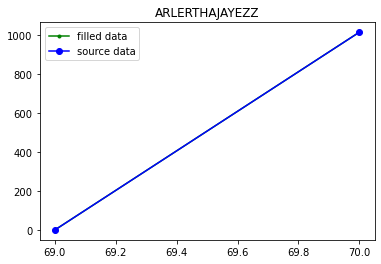

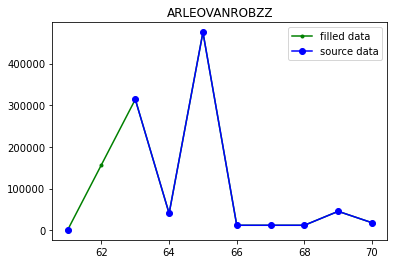

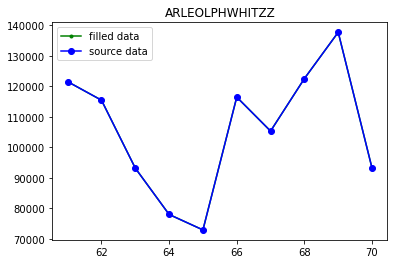

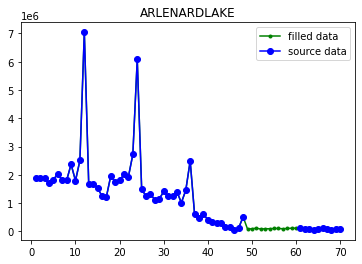

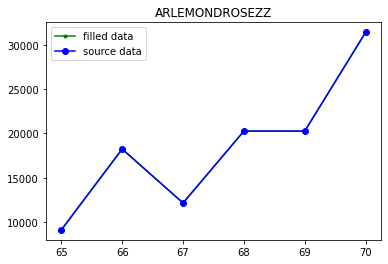

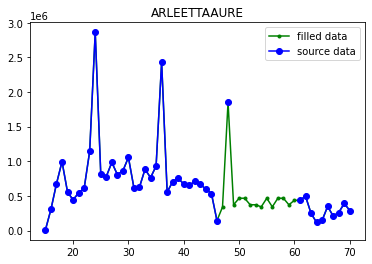

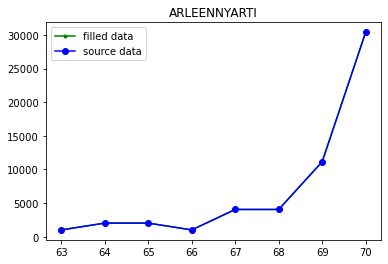

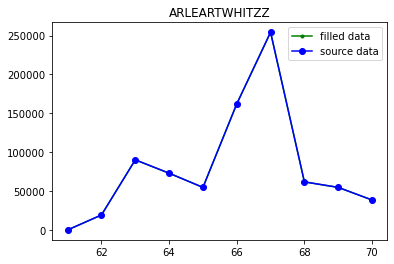

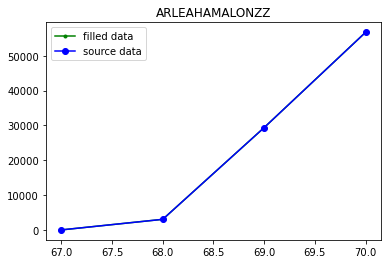

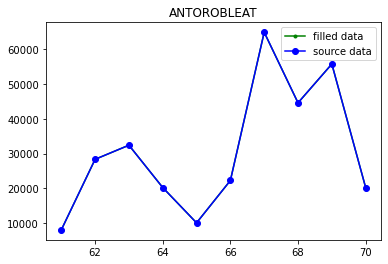

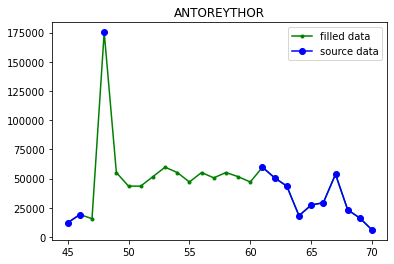

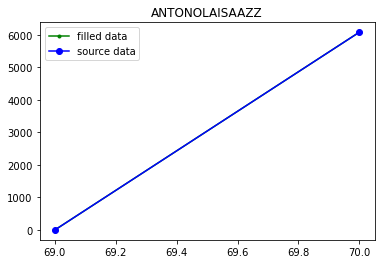

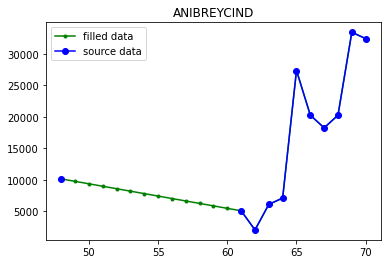

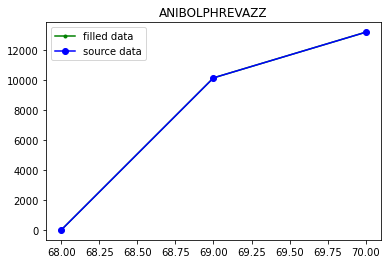

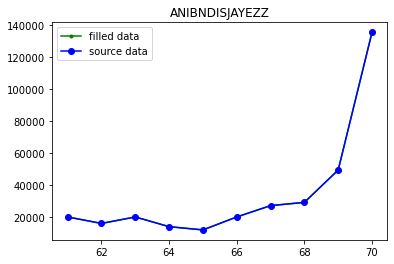

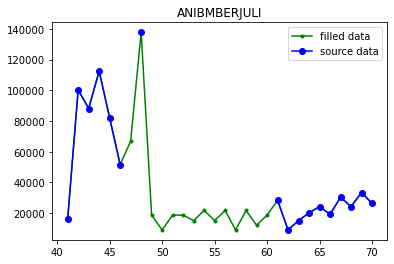

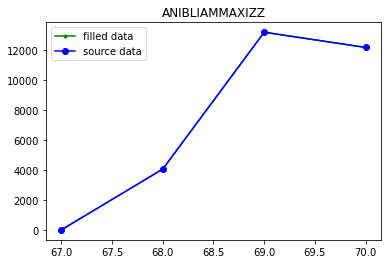

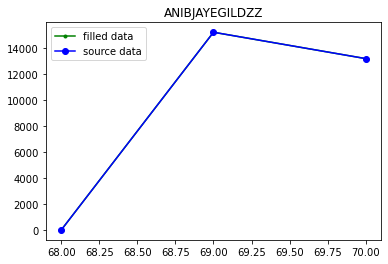

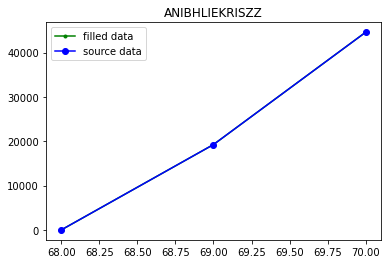

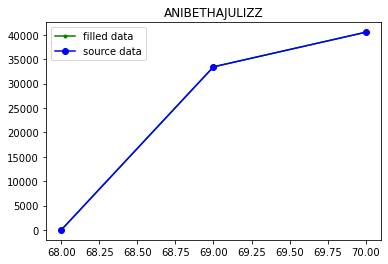

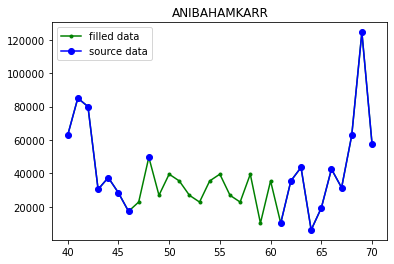

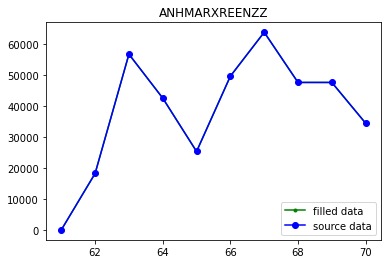

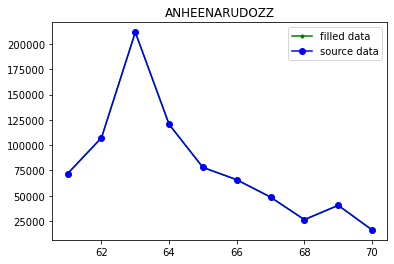

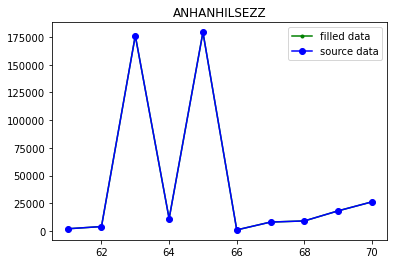

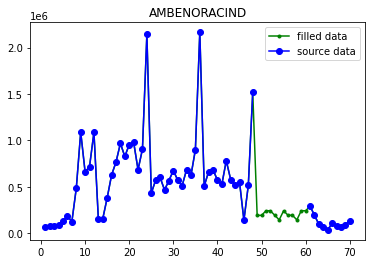

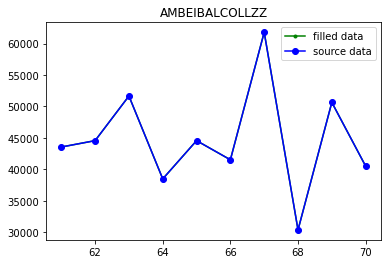

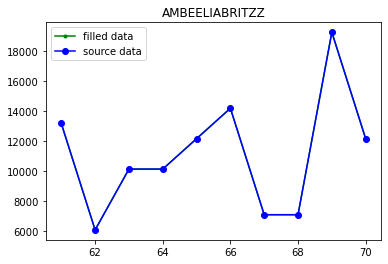

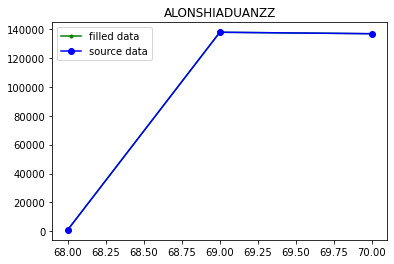

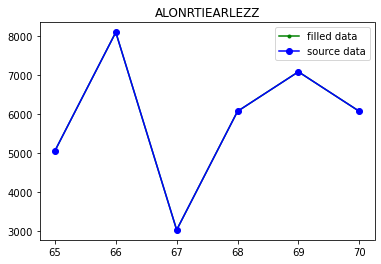

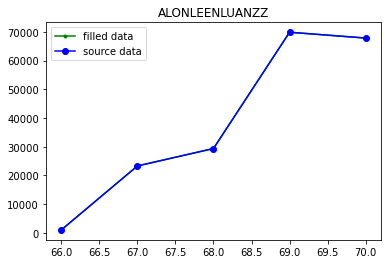

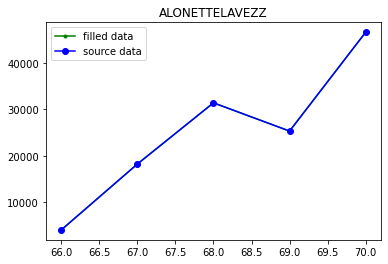

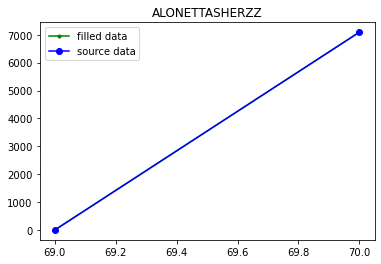

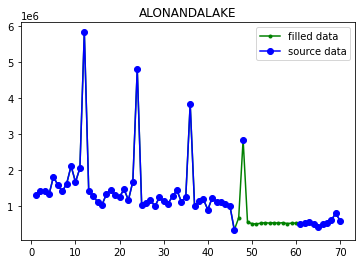

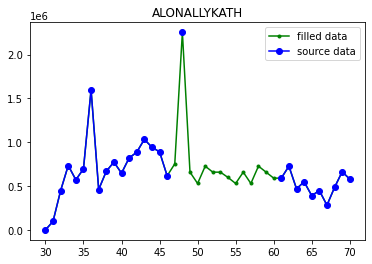

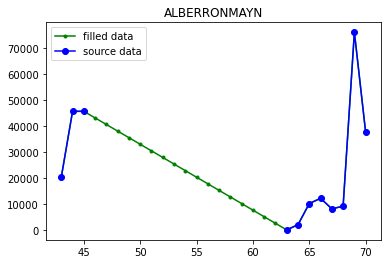

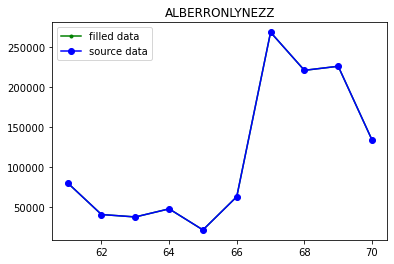

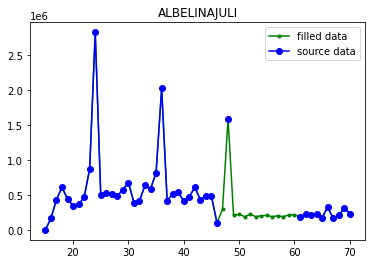

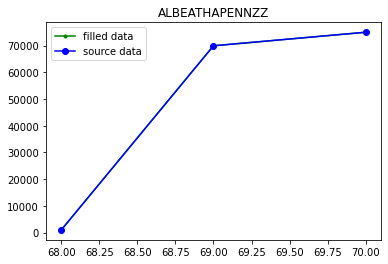

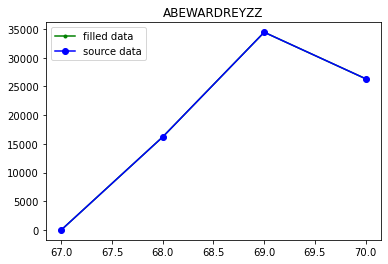

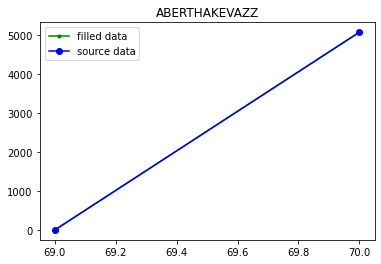

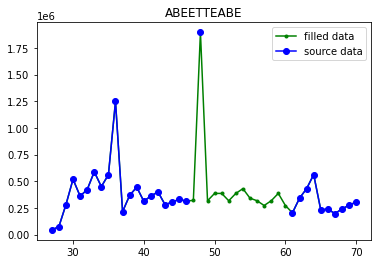

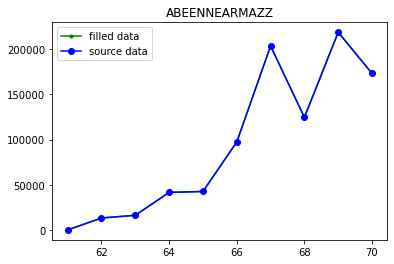

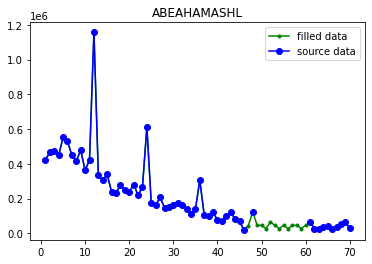

In [280]:
for sku_name in tqdm(test.sku_name.unique()):
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>0:
        ts = make_ts(temp,method = 'smart')

In [137]:
data = train[train.sku_name == "ABEAHAMASHL"]
sellouts = data.sellout.reset_index(drop=True)
months = data.nth_month.reset_index(drop=True)
sellouts_before_fill = []
for i in range(len(sellouts)):
    try:
        n_missing_values = months[i+1] - months[i] - 1
        sellouts_before_fill += [sellouts[i]] + [np.nan]*n_missing_values
    except:
         sellouts_before_fill += [sellouts[i]]
            
months = np.arange(min(months),max(months)+1)
sellouts_before_fill = pd.Series(sellouts_before_fill, index = months)

new_sellouts = fill_missing_values(sellouts_before_fill.copy(), window_size=2, method='smart')

# ACF and PACF

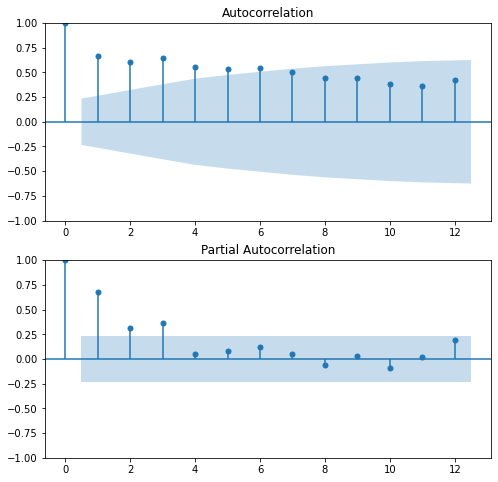

In [138]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(new_sellouts, lags=12, ax=ax1)
plot_pacf(new_sellouts, lags=12, ax=ax2)
plt.show()

In [139]:
pacf_, pacf_conf = pacf(new_sellouts, nlags=12, alpha=0.05, method='ywmle')
pacf_conf = np.array([pacf_conf[:,0] - pacf_, pacf_conf[:,1] - pacf_ ]).T

In [157]:
idx = np.arange(len(pacf_))
idx[pacf_[idx] > pacf_conf[:,1]*1.05]

array([0, 1, 2, 3])

In [140]:
pacf_

array([ 1.        ,  0.66566603,  0.29474747,  0.33082209,  0.02722216,
        0.06023308,  0.09820208,  0.03362523, -0.06370852,  0.0207617 ,
       -0.07559016,  0.01618707,  0.14941315])

In [156]:
pacf_conf

array([[ 0.       ,  0.       ],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605]])

# SESONAL

In [116]:
seas_decompose = seasonal_decompose(new_sellouts, period = 12)

In [119]:
seas_decompose.seasonal

1    -23917.527951
2    -40294.361285
3    -10968.011285
4    -47900.302951
5    -48033.259201
          ...     
66   -16092.102951
67    -8612.786285
68   -22347.377951
69    -3319.861285
70   -43772.327951
Name: seasonal, Length: 70, dtype: float64

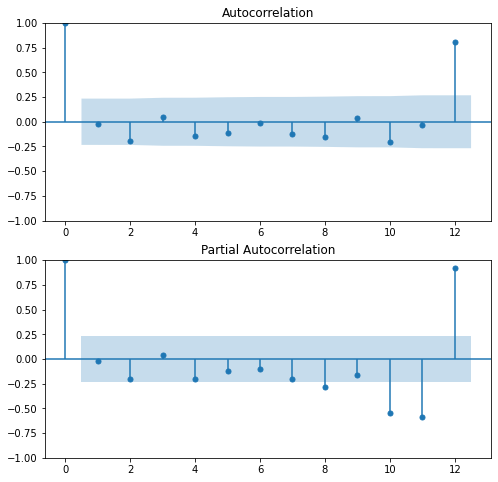

In [121]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(seas_decompose.seasonal, lags=12, ax=ax1)
plot_pacf(seas_decompose.seasonal, lags=12, ax=ax2)
plt.show()

In [122]:
pacf_seas, pacf_seas_conf = pacf(seas_decompose.seasonal, nlags=12, alpha=0.05, method='ywmle')
pacf_seas_conf = np.array([pacf_seas_conf[:,0] - pacf_seas, pacf_seas_conf[:,1] - pacf_seas ]).T

In [161]:
idx = np.arange(len(pacf_seas))
idx[(pacf_seas[idx] > pacf_seas_conf[:,1]*1.05) | (pacf_seas[idx] < pacf_seas_conf[:,0]*1.05)]

array([ 0, 10, 11, 12])

In [123]:
pacf_seas

array([ 1.        , -0.02187166, -0.19264945,  0.03570793, -0.18953767,
       -0.11357718, -0.09436631, -0.17859055, -0.24034375, -0.12581994,
       -0.42577614, -0.33816088,  0.66751315])

In [124]:
pacf_seas_conf

array([[ 0.       ,  0.       ],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605]])

In [131]:
pacf_seas_conf[2,0] * 1.05 < -0.24034375

True

In [132]:
pacf_, pacf_conf = pacf(new_sellouts, nlags=12, alpha=0.05, method='ywmle')
pacf_conf = np.array([pacf_conf[:,0] - pacf_, pacf_conf[:,1] - pacf_ ]).T

In [136]:
pacf_[ pacf_ < pacf_conf[:,0] ] 

array([], dtype=float64)

In [133]:
pacf_

array([ 1.        ,  0.66690973,  0.29406227,  0.33240105,  0.02691491,
        0.05969239,  0.09527418,  0.03641881, -0.06385964,  0.02242915,
       -0.07540993,  0.01223139,  0.14909768])

In [134]:
pacf_conf

array([[ 0.       ,  0.       ],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605],
       [-0.2342605,  0.2342605]])

In [113]:
pacf_ < pacf_conf[:,0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [111]:
pacf_ > pacf_conf[:,1]

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False])

In [ ]:
def parameters_for_sarima(ts, lags=12, seasonality=12, threshold = 0.05):
    #Растояние на котором должна быть точка от доверительного интервала.
    #Например threshold=0.05, тогда если точка находится вне conv_interval*1.05, то она нам подходит, иначе считаем ее незначительной
    #Тем самым отбрасываются точки, которые лежат практически на границе доверительного интервале
    m = 1 + threshold
    idx = np.arange(lags)
    
    #Проверка стационарности
    
    
    #Автокорреляционная функция с интервалами, для определения порядка q
    #Интревалы преобразуем чтобы они были симметриный относительно Ох. Интервалы идентичны интервалам на acf_plot, pacf_plot.
    acf_, acf_conf = acf(ts, nlags=lags, alpha=0.05)
    acf_conf = np.array([acf_conf[:,0] - acf_, acf_conf[:,1] - acf_ ]).T
    q = idx[(acf_[idx] > acf_conf[:,1]*m) | (acf_[idx] < acf_conf[:,0]*m)]
    
    #Частная автокорреляционная функция с интервалами, для определения порядка p
    pacf_, pacf_conf = pacf(ts, nlags=lags, alpha=0.05)
    pacf_conf = np.array([pacf_conf[:,0] - pacf_, pacf_conf[:,1] - pacf_ ]).T
    p = idx[(pacf_[idx] > pacf_conf[:,1]*m) | (pacf_[idx] < pacf_conf[:,0]*m)]
    
    #Проверка стационарности сезонной составляющей
    seas_decompose = seasonal_decompose(ts, period = seasonality)
    
    
    #Сезонная автокорреляционная функция с интервалами, для определения порядка Q
    acf_seas, acf_seas_conf = acf(seas_decompose.seasonal, nlags=lags, alpha=0.05, method='ywmle')
    acf_seas_conf = np.array([acf_seas_conf[:,0] - acf_seas, acf_seas_conf[:,1] - acf_seas ]).T
    Q = idx[(acf_seas[idx] > acf_seas_conf[:,1]*1.05) | (acf_seas[idx] < acf_seas_conf[:,0]*1.05)]
    
     #Частная сезонная автокорреляционная функция с интервалами, для определения порядка P
    pacf_seas, pacf_seas_conf = pacf(seas_decompose.seasonal, nlags=lags, alpha=0.05, method='ywmle')
    pacf_seas_conf = np.array([pacf_seas_conf[:,0] - pacf_seas, pacf_seas_conf[:,1] - pacf_seas ]).T
    P = idx[(pacf_seas[idx] > pacf_seas_conf[:,1]*1.05) | (pacf_seas[idx] < pacf_seas_conf[:,0]*1.05)]
    
    
    
    

In [92]:
acf_conf

array([[ 0.        ,  0.        ],
       [-0.34647596,  0.34647596],
       [-0.44236833,  0.44236833],
       [-0.46159325,  0.46159325],
       [-0.47592109,  0.47592109],
       [-0.47970951,  0.47970951],
       [-0.47971822,  0.47971822],
       [-0.48033355,  0.48033355],
       [-0.48203627,  0.48203627],
       [-0.48965652,  0.48965652],
       [-0.4993843 ,  0.4993843 ],
       [-0.50282986,  0.50282986],
       [-0.5069146 ,  0.5069146 ],
       [-0.51267316,  0.51267316],
       [-0.52251249,  0.52251249]])

In [69]:
shape = acf_conf.shape

(2, 15)

In [48]:
acf_conf[:,1] - acf_ 

array([0.        , 0.34647596, 0.44236833, 0.46159325, 0.47592109,
       0.47970951, 0.47971822, 0.48033355, 0.48203627, 0.48965652,
       0.4993843 , 0.50282986, 0.5069146 , 0.51267316, 0.52251249])

In [41]:
acf_conf[0]-acf_

ValueError: operands could not be broadcast together with shapes (2,) (15,) 

In [17]:
indexes_of_observations = new_sellouts.index
sellouts_for_training = new_sellouts.reset_index(drop=True)

In [18]:
configurations = sarimax_gridsearch(sellouts_for_training, pdq, pdqs, maxiter=50, freq='M')
model = sm.tsa.statespace.SARIMAX(sellouts_for_training,
                                  order=configurations.loc[0,'pdq'],
                                  seasonal_order=configurations.loc[0,'pdqs'],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
output = model.fit()
result = output.predict()
result.index = indexes_of_observations-1

In [19]:
times_for_pred=np.array([71,72,73,74])
times_for_pred = times_for_pred - indexes_of_observations[-1] + (len(result)-1)
preds=[]
for t in times_for_pred:
    preds.append(output.predict(t).item())
preds = pd.Series(data=preds, index=[71,72,73,74])

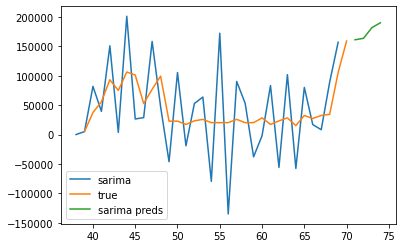

In [20]:
plt.plot(result)
plt.plot(new_sellouts)
plt.plot(preds)
plt.legend(['sarima','true','sarima preds'])
plt.show()

In [88]:
s=2016
for y in range(2016,2023):
    for m in range(1,13):
        print(f'{m}.{y}: { 12*(y-s)+m }')

1.2016: 1
2.2016: 2
3.2016: 3
4.2016: 4
5.2016: 5
6.2016: 6
7.2016: 7
8.2016: 8
9.2016: 9
10.2016: 10
11.2016: 11
12.2016: 12
1.2017: 13
2.2017: 14
3.2017: 15
4.2017: 16
5.2017: 17
6.2017: 18
7.2017: 19
8.2017: 20
9.2017: 21
10.2017: 22
11.2017: 23
12.2017: 24
1.2018: 25
2.2018: 26
3.2018: 27
4.2018: 28
5.2018: 29
6.2018: 30
7.2018: 31
8.2018: 32
9.2018: 33
10.2018: 34
11.2018: 35
12.2018: 36
1.2019: 37
2.2019: 38
3.2019: 39
4.2019: 40
5.2019: 41
6.2019: 42
7.2019: 43
8.2019: 44
9.2019: 45
10.2019: 46
11.2019: 47
12.2019: 48
1.2020: 49
2.2020: 50
3.2020: 51
4.2020: 52
5.2020: 53
6.2020: 54
7.2020: 55
8.2020: 56
9.2020: 57
10.2020: 58
11.2020: 59
12.2020: 60
1.2021: 61
2.2021: 62
3.2021: 63
4.2021: 64
5.2021: 65
6.2021: 66
7.2021: 67
8.2021: 68
9.2021: 69
10.2021: 70
11.2021: 71
12.2021: 72
1.2022: 73
2.2022: 74
3.2022: 75
4.2022: 76
5.2022: 77
6.2022: 78
7.2022: 79
8.2022: 80
9.2022: 81
10.2022: 82
11.2022: 83
12.2022: 84


In [60]:
output.predict(11)

11    59948.135329
dtype: float64

#### Простые методы: 
#### 1) Историческое среднее
#### 2) Историческая медиана
#### 3) Среднее по последним 3м наблюдениям
#### 4) seasonal naive (11.2021 = mean(11.2016, ... ,11.2021))

In [206]:
lst=[]
columns=["Item_ID", "Target"]
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"]

for sku_name in tqdm(test.sku_name.unique()):
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>9:
        ts = make_ts(train[train.sku_name == sku_name], method = 'smart')
        for i in range(4):
            lst.append([sku_name + extra[i], ts.mean()])
    if temp.shape[0] == 0:
        for i in range(4):
            lst.append([sku_name + extra[i], 1000])
    else:
        for i in range(4):
            lst.append([sku_name + extra[i], temp.sellout.mean()])
sub = pd.DataFrame(data=lst, columns = columns)

  0%|          | 0/382 [00:00<?, ?it/s]

In [208]:
sub.to_csv(os.getcwd()+'\submission 4 (historical_maen, fill missing values smart if n_rows more 9).csv',index=False)

In [218]:
lst=[]
columns=["Item_ID", "Target"]
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"]

for sku_name in tqdm(test.sku_name.unique()):
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>9:
        ts = make_ts(train[train.sku_name == sku_name], method = 'smart')
        for i in range(4):
            lst.append([sku_name + extra[i], ts.quantile(0.5)])
    if temp.shape[0] == 0:
        for i in range(4):
            lst.append([sku_name + extra[i], 1000])
    else:
        for i in range(4):
            lst.append([sku_name + extra[i], temp.sellout.quantile(0.5)])
sub = pd.DataFrame(data=lst, columns = columns)

  0%|          | 0/382 [00:00<?, ?it/s]

In [219]:
sub.to_csv(os.getcwd()+'\submission 5 (historical_median, fill missing values smart if n_rows more 9).csv',index=False)

In [232]:
lst=[]
columns=["Item_ID", "Target"]
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"]

for sku_name in tqdm(test.sku_name.unique()):
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>9:
        ts = make_ts(train[train.sku_name == sku_name], method = 'smart')
        for i in range(4):
            lst.append([sku_name + extra[i], ts[-3:].mean()])
    if temp.shape[0] == 0:
        for i in range(4):
            lst.append([sku_name + extra[i], 1000])
    else:
        for i in range(4):
            try:
                lst.append([sku_name + extra[i], temp.sellout[-3:].mean()])
            except:
                lst.append([sku_name + extra[i], temp.sellout.mean()])
sub = pd.DataFrame(data=lst, columns = columns)

  0%|          | 0/382 [00:00<?, ?it/s]

In [233]:
sub.to_csv(os.getcwd()+'\submission 6 (3 last observations mean, fill missing values smart if n_rows more 9).csv',index=False)

In [350]:
lst=[]
columns=["Item_ID", "Target"]
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"]
months_array = [[11,23,35,47,59,71],
         [12,24,36,48,60,72],
         [1,13,25,37,49,61,73],
          [2,14,26,38,50,62,74]] #11,12,1,2 месяцы

for sku_name in tqdm(test.sku_name.unique()):
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>9:
        ts = make_ts(train[train.sku_name == sku_name], method = 'smart')
        for i, months in enumerate(months_array):
            have = []
            for month in months:
                try:
                    have.append(ts[month])
                except:
                    pass
            have = np.array(have)
            mean =  have.mean()
            if np.isnan(mean):
                lst.append([sku_name + extra[i], ts.mean()])
            else:
                lst.append([sku_name + extra[i], mean])
    
    if temp.shape[0] == 0:
        for i in range(4):
            lst.append([sku_name + extra[i], 1000])
    else:
        for i in range(4):
            try:
                lst.append([sku_name + extra[i], temp.sellout[-3:].mean()])
            except:
                lst.append([sku_name + extra[i], temp.sellout.mean()])
sub = pd.DataFrame(data=lst, columns = columns)

  0%|          | 0/382 [00:00<?, ?it/s]

In [351]:
sub

Item_ID         Target
0     YOSHTLYNYOSHZZ_11_2021   32213.400000
1     YOSHTLYNYOSHZZ_12_2021   32213.400000
2      YOSHTLYNYOSHZZ_1_2022       0.000000
3      YOSHTLYNYOSHZZ_2_2022   12156.000000
4     YOSHTLYNYOSHZZ_11_2021   46935.666667
...                      ...            ...
2387      ABEAHAMASHL_2_2022  131690.000000
2388     ABEAHAMASHL_11_2021   50650.000000
2389     ABEAHAMASHL_12_2021   50650.000000
2390      ABEAHAMASHL_1_2022   50650.000000
2391      ABEAHAMASHL_2_2022   50650.000000

[2392 rows x 2 columns]

In [352]:
sub.to_csv(os.getcwd()+'\submission 8 (seasonal naive median, fill missing values smart if n_rows more 9).csv',index=False)